In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [111]:
def get_weekday_name(date):
    '''
    date : 'YYYY-MM-DD'
    return : Monday
    '''
    return date.strftime('%A')

# Function to get all days in a time period
def get_all_dates(start_date, end_date):
    delta = end_date - start_date
    return [start_date + timedelta(days=i) for i in range(delta.days + 1)]


# EDA

In [4]:
df = pd.read_csv('./Project3Data.csv')
# df = df.dropna()
df.head()

,Date,Region,Unit Price,Quantity Ordered,Distance,Delivery Fees,Discount Applied
0,2023-01-01,1,16.0,21,2,1.0,0
1,2023-01-01,2,16.0,18,5,2.5,0
2,2023-01-01,3,16.0,10,9,4.5,0
3,2023-01-01,4,16.0,1,15,7.5,0
4,2023-01-02,1,16.0,20,2,1.0,0


- check week day name

In [5]:
# check if we have every week day evenly -> no (sunday data is very few)
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
df['dow'] = df.Date.apply(lambda x: get_weekday_name(x))
df['dow'].value_counts() 

dow
Sunday       72
Monday       68
Tuesday      68
Wednesday    68
Thursday     68
Friday       68
Saturday     68
Name: count, dtype: int64

- check dataset

In [9]:
# discount applied date
df[['Region','Discount Applied','Date']].groupby(['Region','Discount Applied']).agg({'Date':'min'})

Date
Region Discount Applied           
1      0                2023-01-01
2      0                2023-01-01
3      0                2023-01-01
       1                2023-03-01
4      0                2023-01-01
       1                2023-03-01

In [13]:
# unique values
df[['Region','Unit Price','Distance','Delivery Fees','Discount Applied']].drop_duplicates().sort_values(by=['Region','Distance'])

,Region,Unit Price,Distance,Delivery Fees,Discount Applied
0,1,16.0,2,1.000,0
1,2,16.0,5,2.500,0
2,3,16.0,9,4.500,0
238,3,15.2,9,4.500,1
3,4,16.0,15,7.500,0
239,4,16.0,15,7.125,1


# Plot Average

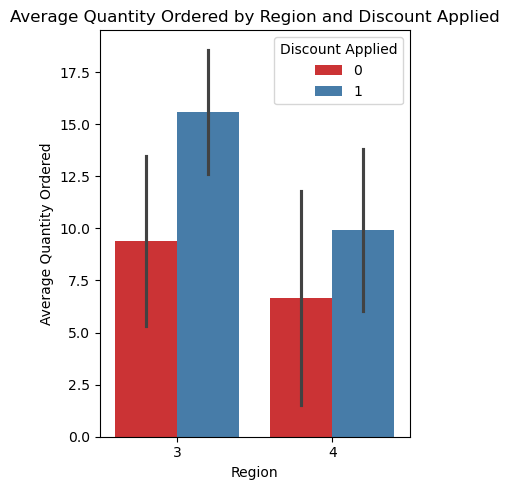

In [162]:
plt.figure(figsize=(4, 5))
sns.barplot(
    data=df[df.Region.isin([3,4])],
    x='Region',
    y='Quantity Ordered',
    hue='Discount Applied',
    errorbar='sd',  # std bar
    palette='Set1'
)

# title, label
plt.xlabel('Region')
plt.ylabel('Average Quantity Ordered')
plt.title('Average Quantity Ordered by Region and Discount Applied')
plt.legend(title='Discount Applied')

plt.tight_layout()
plt.show()

# DID plot

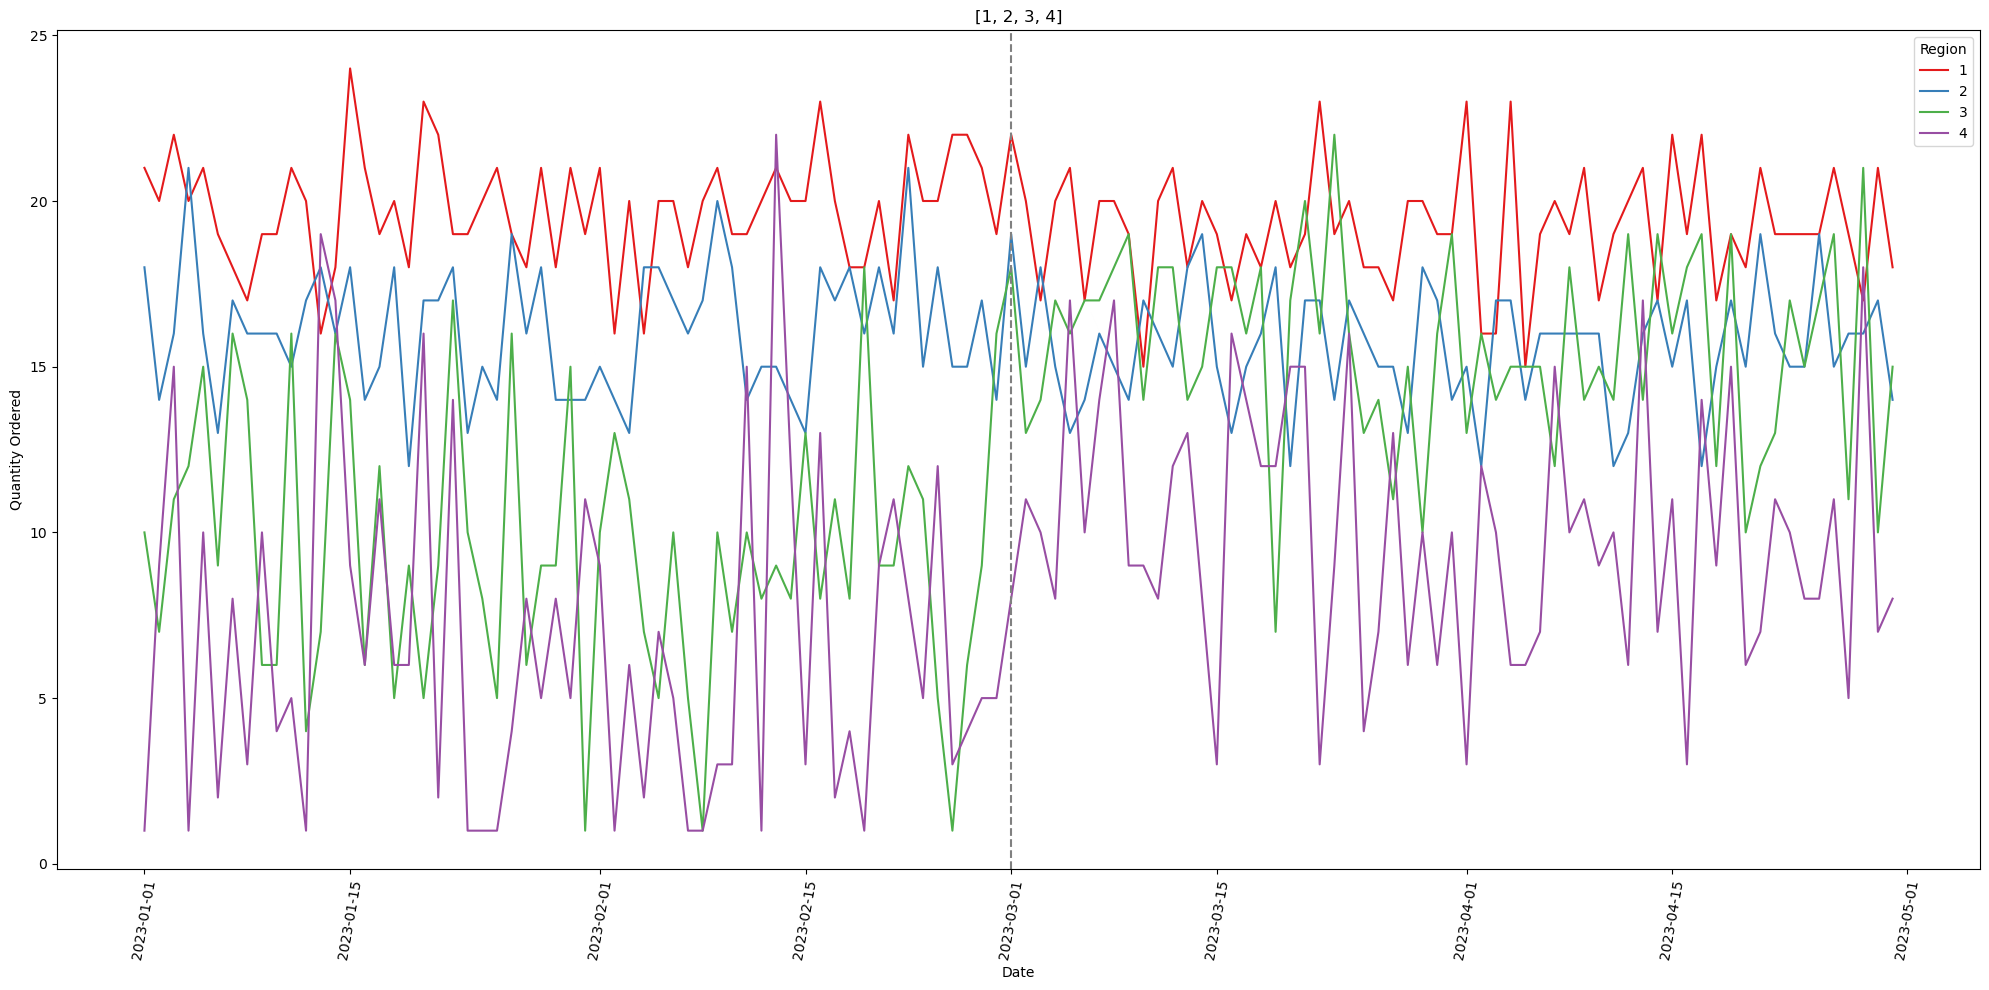

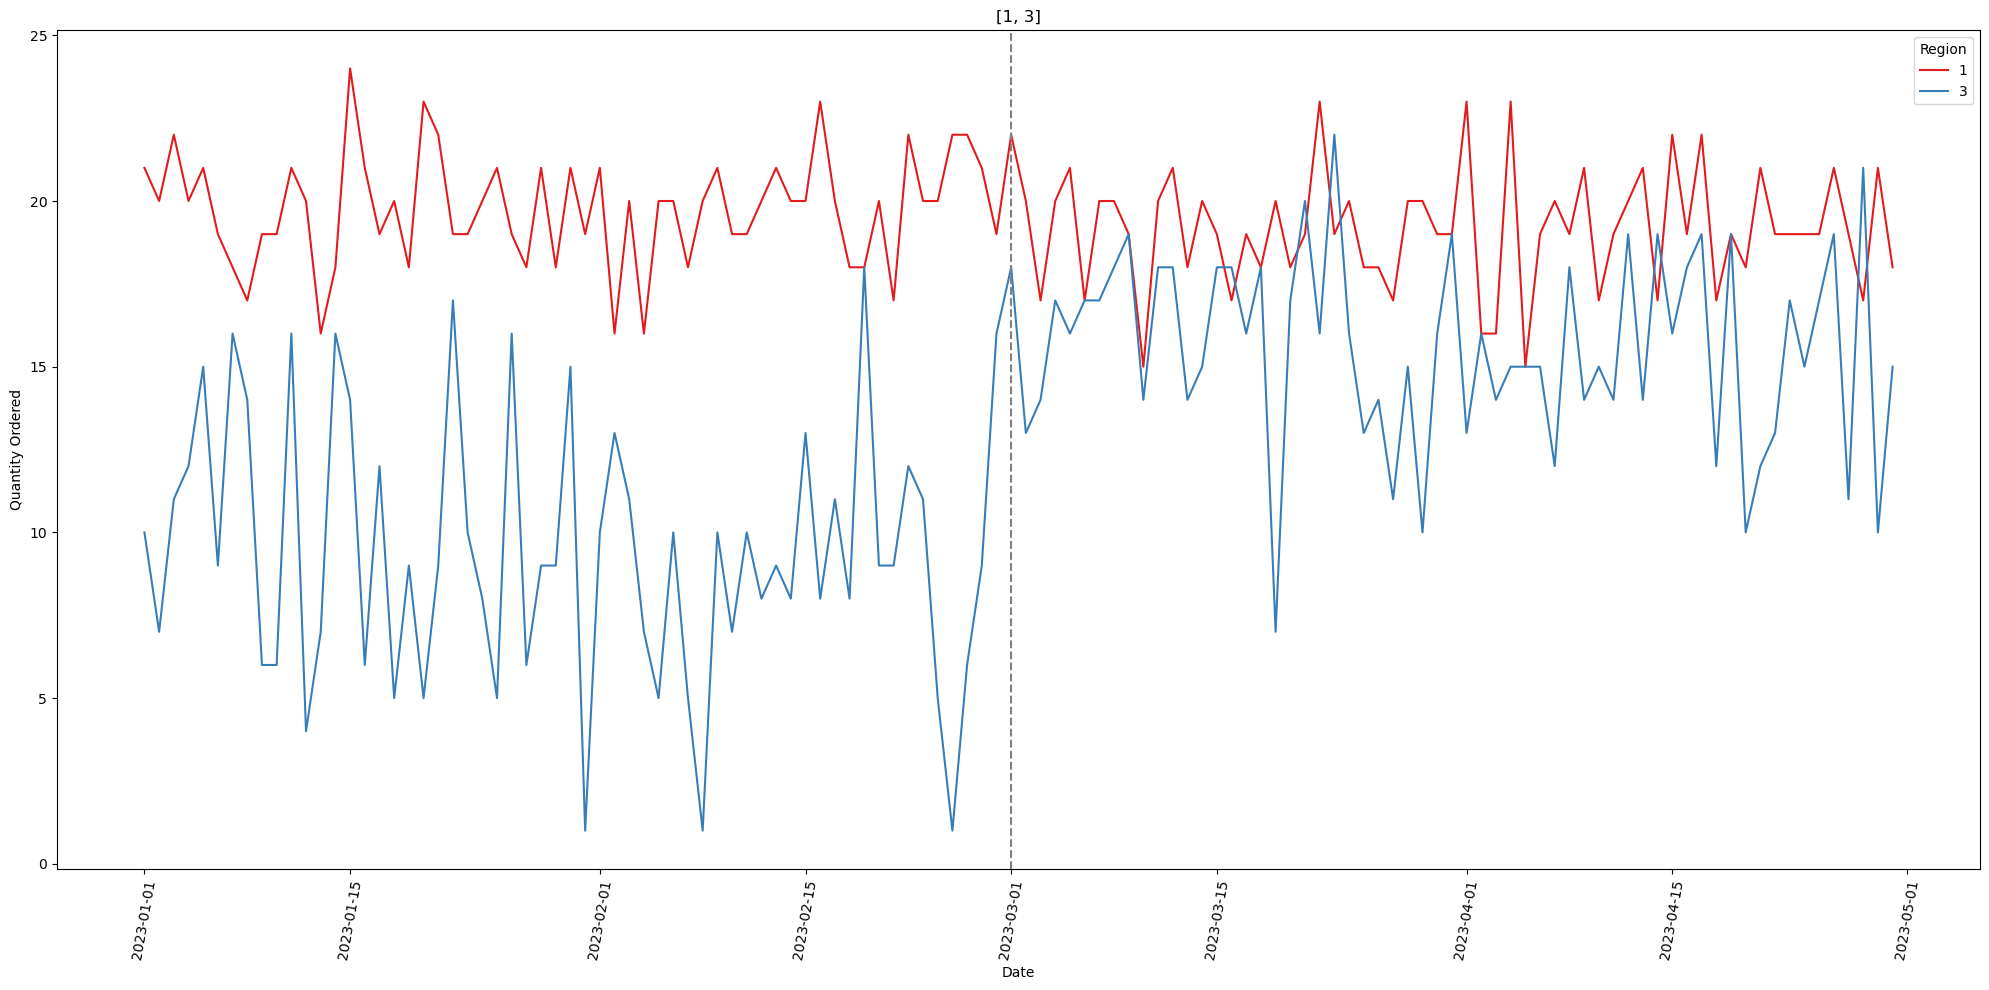

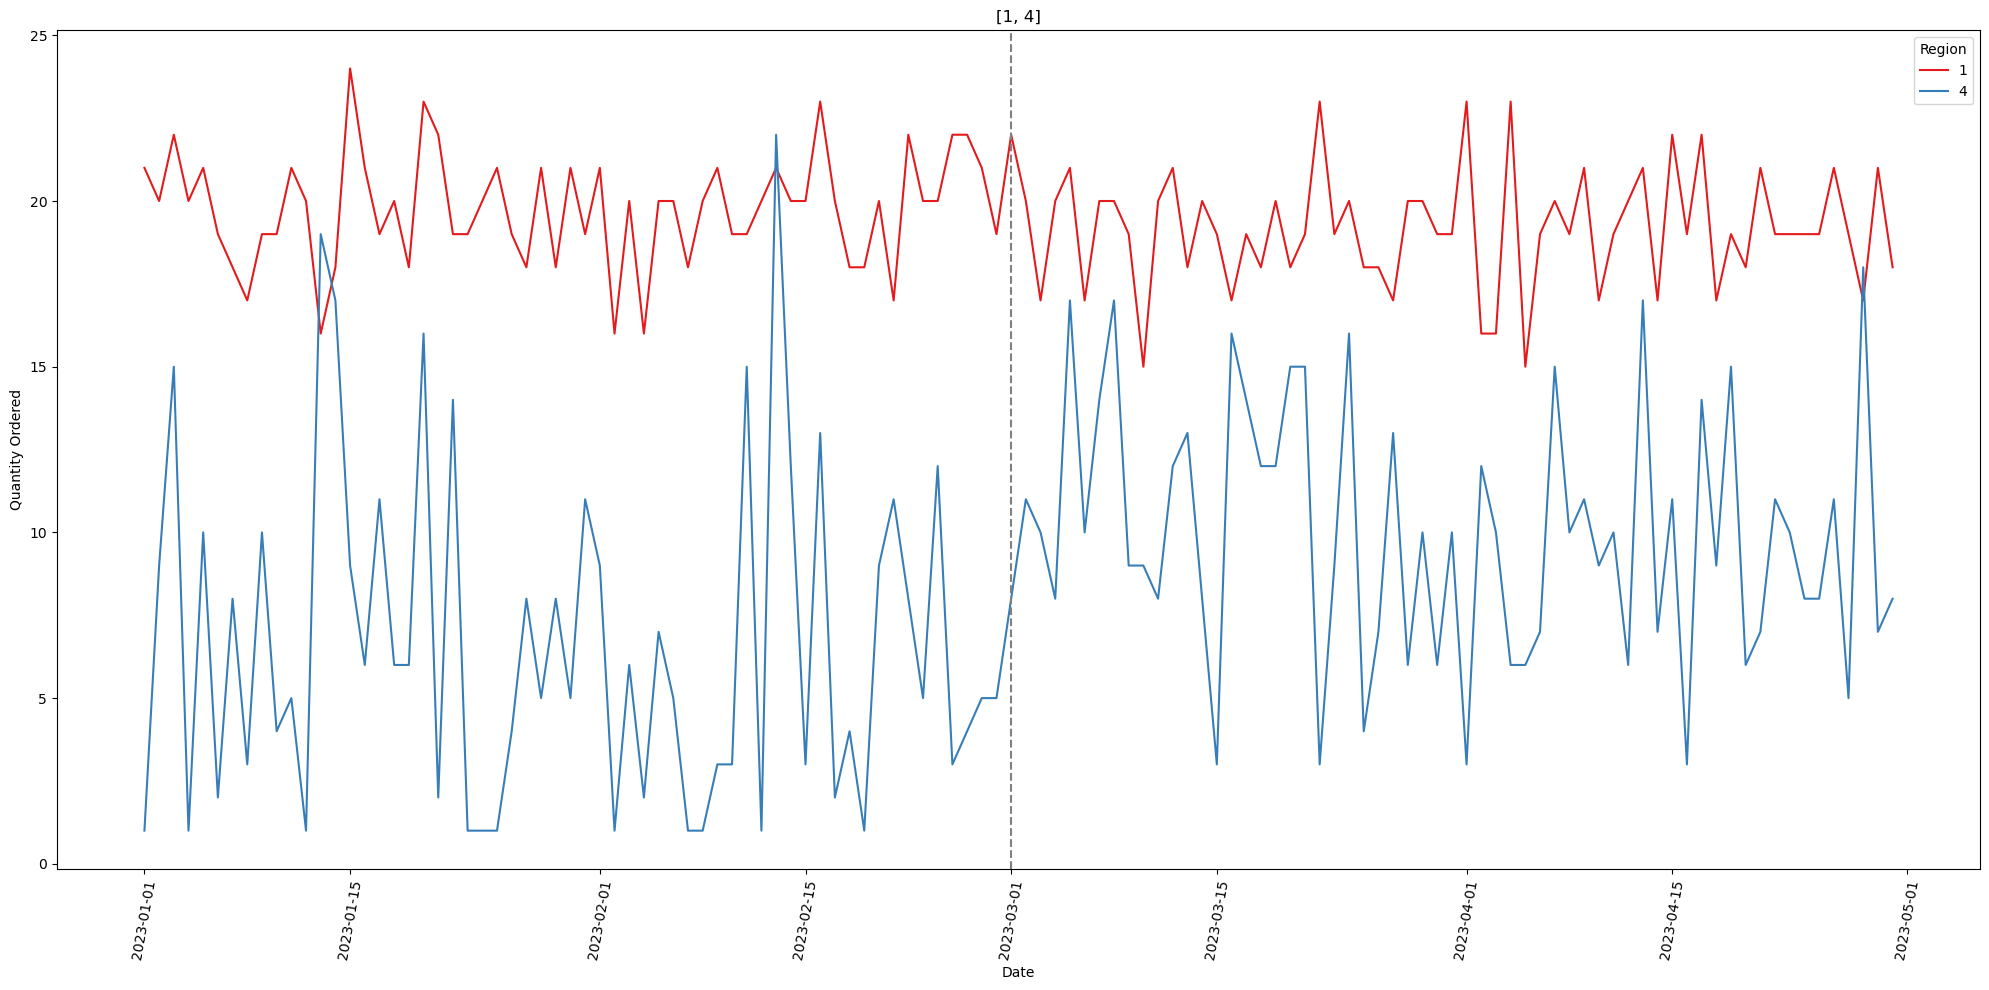

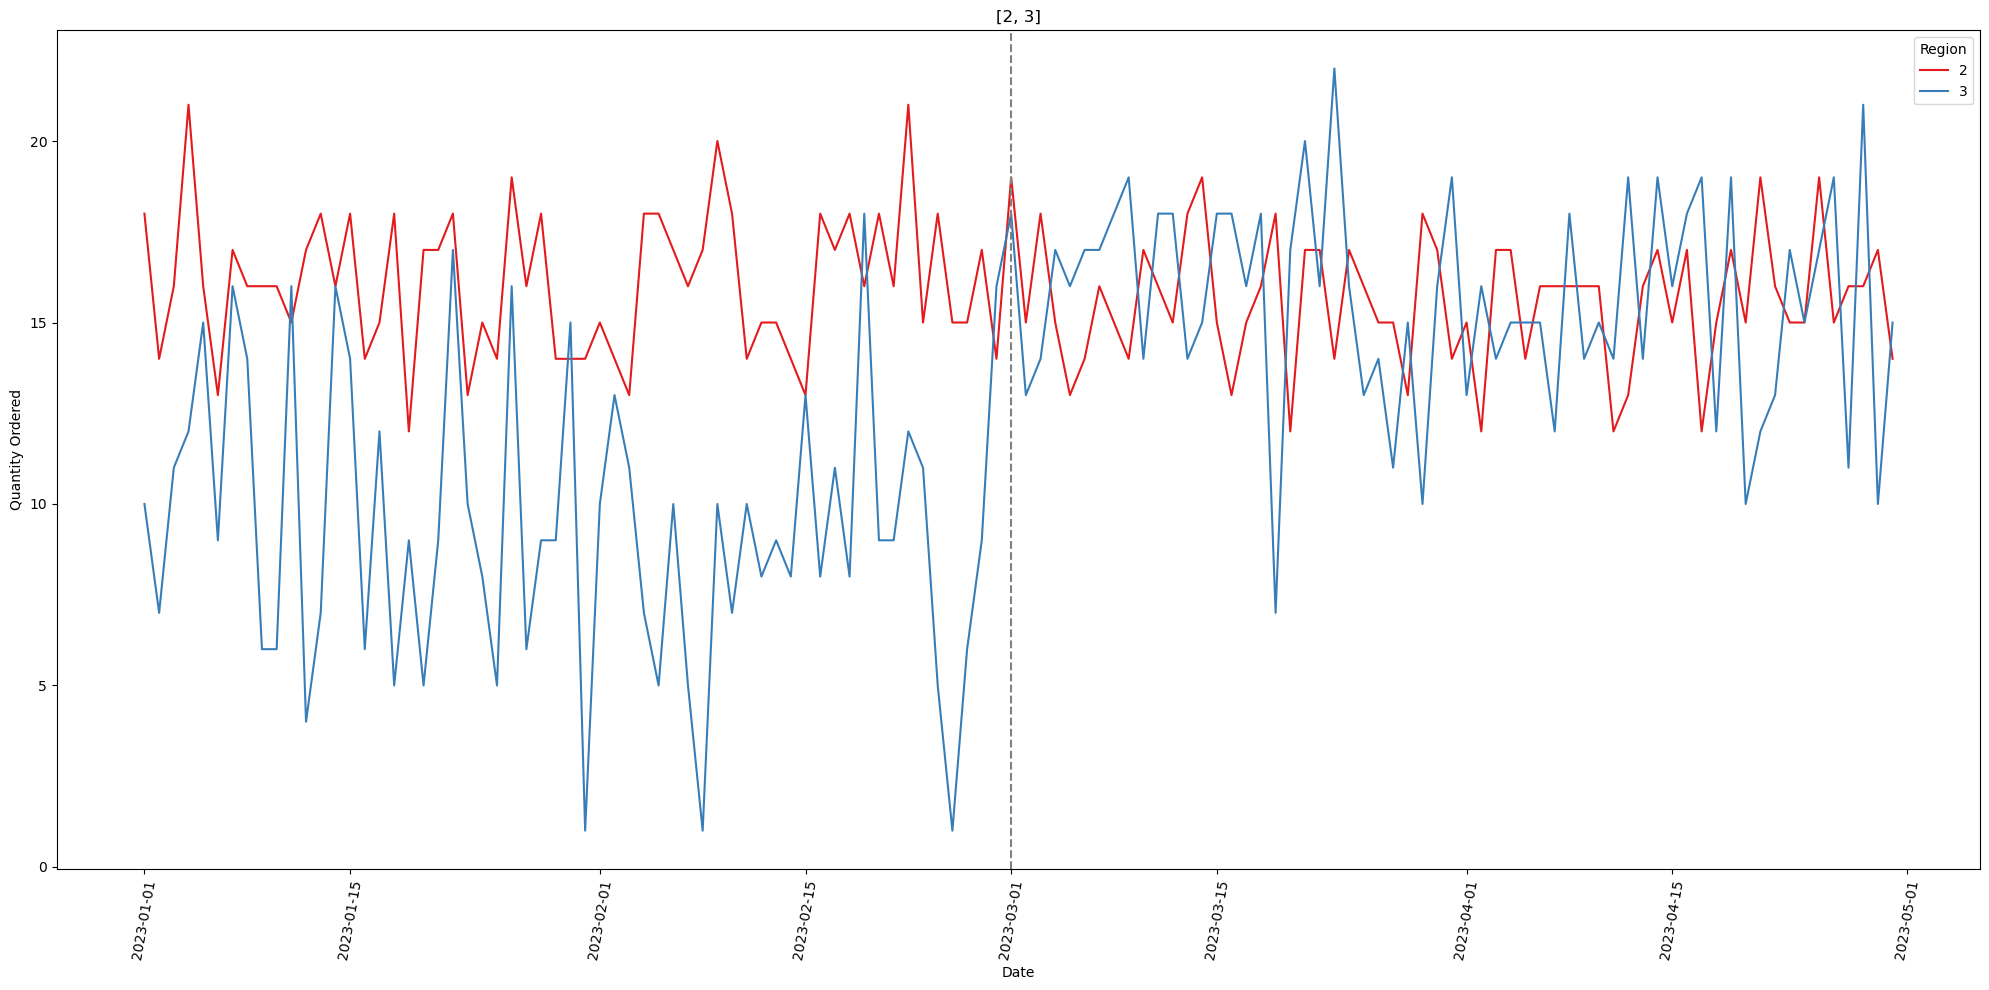

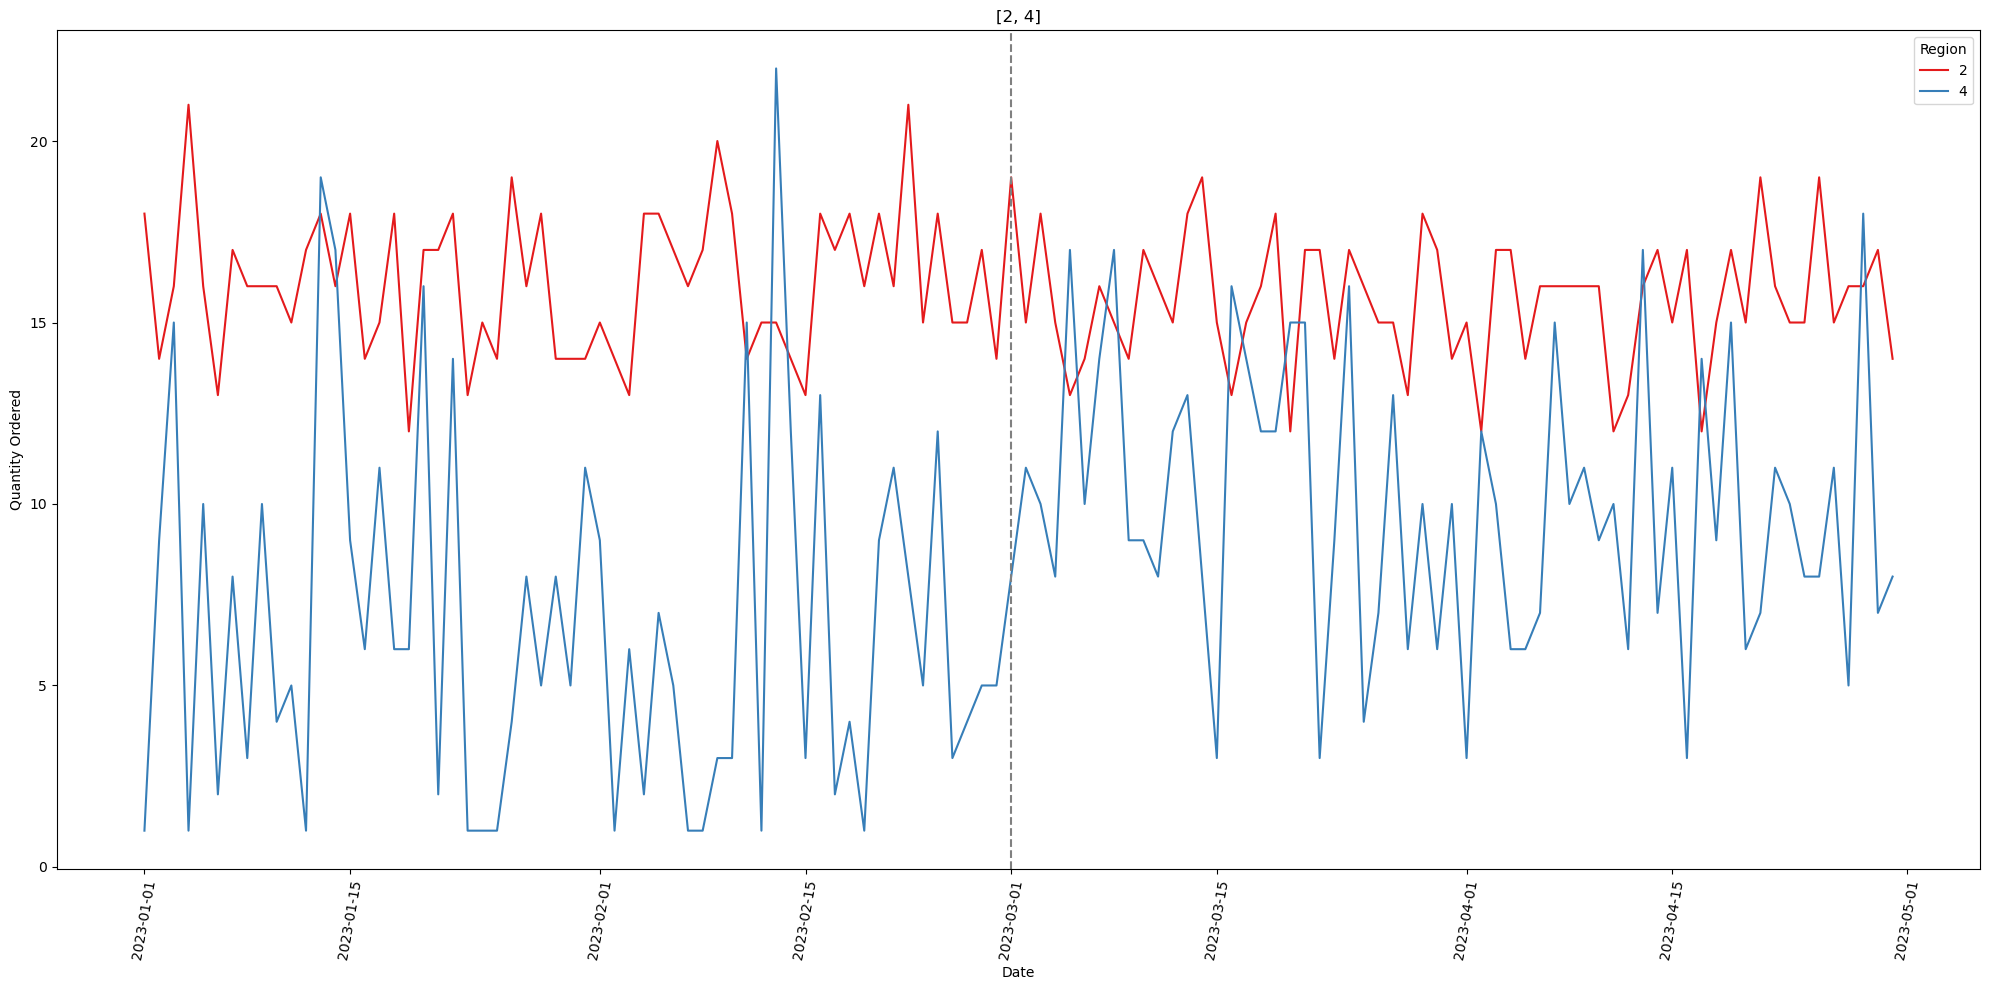

In [172]:
# plot
region_combination = [[1,2,3,4],[1,3],[1,4],[2,3],[2,4]]

for i, region in enumerate(region_combination):
    plt.figure(figsize=(20, 10))
    subset = df[df['Region'].isin(region)]
    sns.lineplot(data=subset, x='Date',y='Quantity Ordered', hue='Region', palette='Set1')

    # discount applied date
    phase_2_start = datetime(2023,3,1)
    plt.axvline(x=phase_2_start, color='grey', linestyle='--', label='Phase 2 Start')

    plt.title(f'{region}')    
    plt.xticks(rotation=80)
    plt.tight_layout()
    plt.show()

# regression

In [72]:
def perform_regression(phase_data, dependent_var, trash, case):
    # Define the independent variables (Treatment, Post, Treatment_Post)
    X = phase_data[['Treatment', 'Phase_2', 'Phase_3', 'Treatment_Phase_2', 'Treatment_Phase_3']]
    
    # Add a constant (intercept) to the independent variables
    X = sm.add_constant(X)
    
    # Define the dependent variable
    y = phase_data[dependent_var]
    
    # Fit the regression model
    model = sm.OLS(y, X).fit()

    results = pd.DataFrame({
        'Case': case,
        'Phase&Trash': trash,
        'Variable': model.params.index,
        'Coefficient': model.params.values,
        'P-value': model.pvalues.values
    })
    
    # Print the summary of the regression
    print(model.summary())
    
    # Fit a simple linear regression model
    residuals = model.resid
    fitted_values = model.fittedvalues  
    
    plt.figure(figsize=(18, 12))
    print("\n--- Check Linear Regression Assumptions ---")

    # 1. Independence (Scatter plot of residuals vs observation index)
    plt.subplot(2, 2, 1)
    plt.scatter(range(len(residuals)), residuals, color='purple', alpha=0.6)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title('Independence Assumption: Residuals vs Observation Index')
    plt.xlabel('Observation Index')
    plt.ylabel('Residuals')
    plt.grid(True)

    # 2. Homoskedasticity (Residuals vs Fitted Values)
    plt.subplot(2, 2, 2)
    plt.scatter(fitted_values, residuals, color='green', alpha=0.6)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title('Homoskedasticity Assumption: Residuals vs Fitted Values')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.grid(True)

    # 3. Normality of Residuals (Histogram)
    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=30, color='orange', alpha=0.6)
    plt.title('Normality Assumption: Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # 4. Multicollinearity Check
    print("\n--- Multicollinearity Check (Variance Inflation Factor) ---")
    
    # Calculating VIF for each independent variable (excluding the constant)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

    # Exclude the constant (intercept) from the VIF results
    vif_data = vif_data[vif_data["Feature"] != "const"]
    print(vif_data)

    return results

### case_1 : raw_data

In [73]:
all_results = []

Regression for PaperContaminant:
                            OLS Regression Results                            
Dep. Variable:       PaperContaminant   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     19.45
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           1.80e-12
Time:                        13:25:27   Log-Likelihood:                -176.94
No. Observations:                  83   AIC:                             365.9
Df Residuals:                      77   BIC:                             380.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const

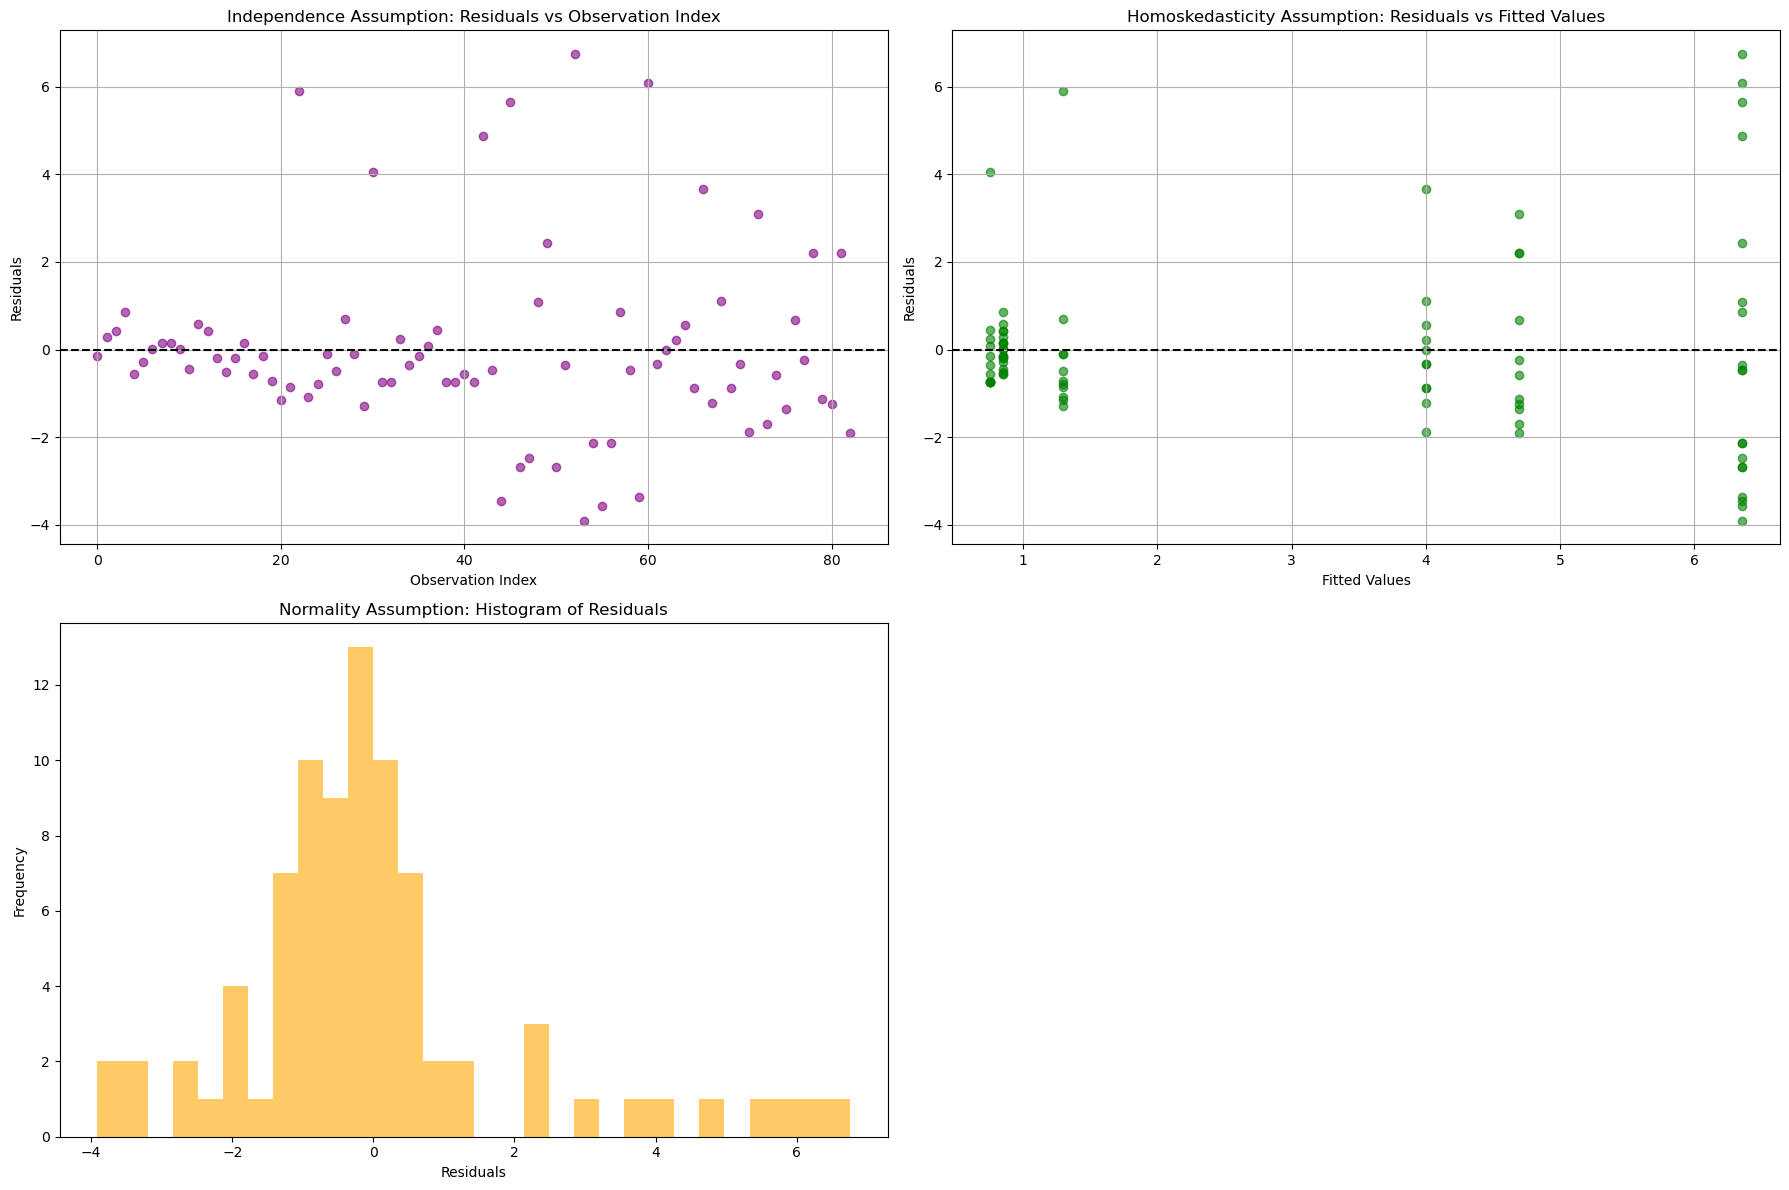


--- Multicollinearity Check (Variance Inflation Factor) ---
             Feature       VIF
1          Treatment  2.183893
2            Phase_2  2.320862
3            Phase_3  2.260621
4  Treatment_Phase_2  2.739379
5  Treatment_Phase_3  2.667089
Regression for PlasticContaminant:
                            OLS Regression Results                            
Dep. Variable:     PlasticContaminant   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     17.03
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           2.63e-11
Time:                        13:25:27   Log-Likelihood:                -293.14
No. Observations:                  83   AIC:                             598.3
Df Residuals:                      77   BIC:                             612.8
Df Model:                           5                                         
Covaria

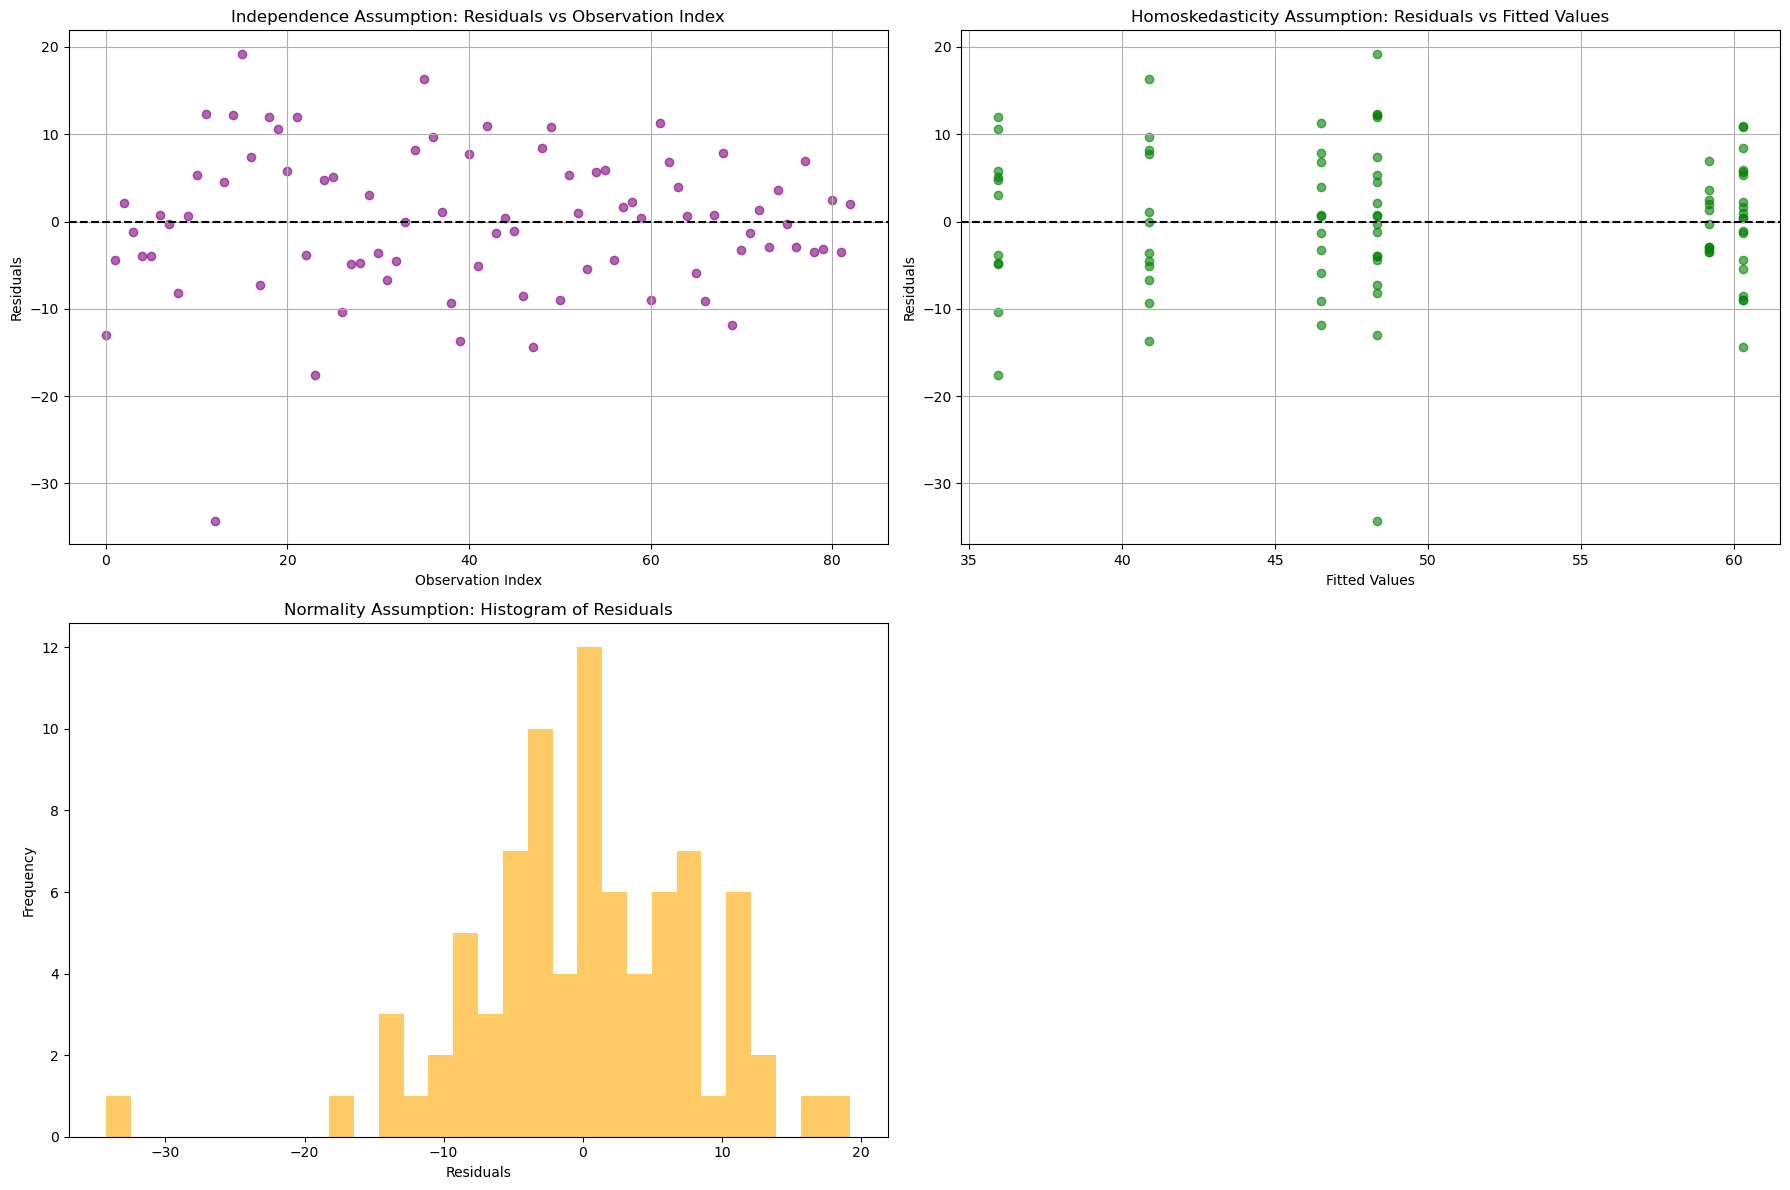


--- Multicollinearity Check (Variance Inflation Factor) ---
             Feature       VIF
1          Treatment  2.183893
2            Phase_2  2.320862
3            Phase_3  2.260621
4  Treatment_Phase_2  2.739379
5  Treatment_Phase_3  2.667089
Regression for CanContaminant:
                            OLS Regression Results                            
Dep. Variable:         CanContaminant   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     20.28
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           7.39e-13
Time:                        13:25:27   Log-Likelihood:                -297.79
No. Observations:                  83   AIC:                             607.6
Df Residuals:                      77   BIC:                             622.1
Df Model:                           5                                         
Covariance 

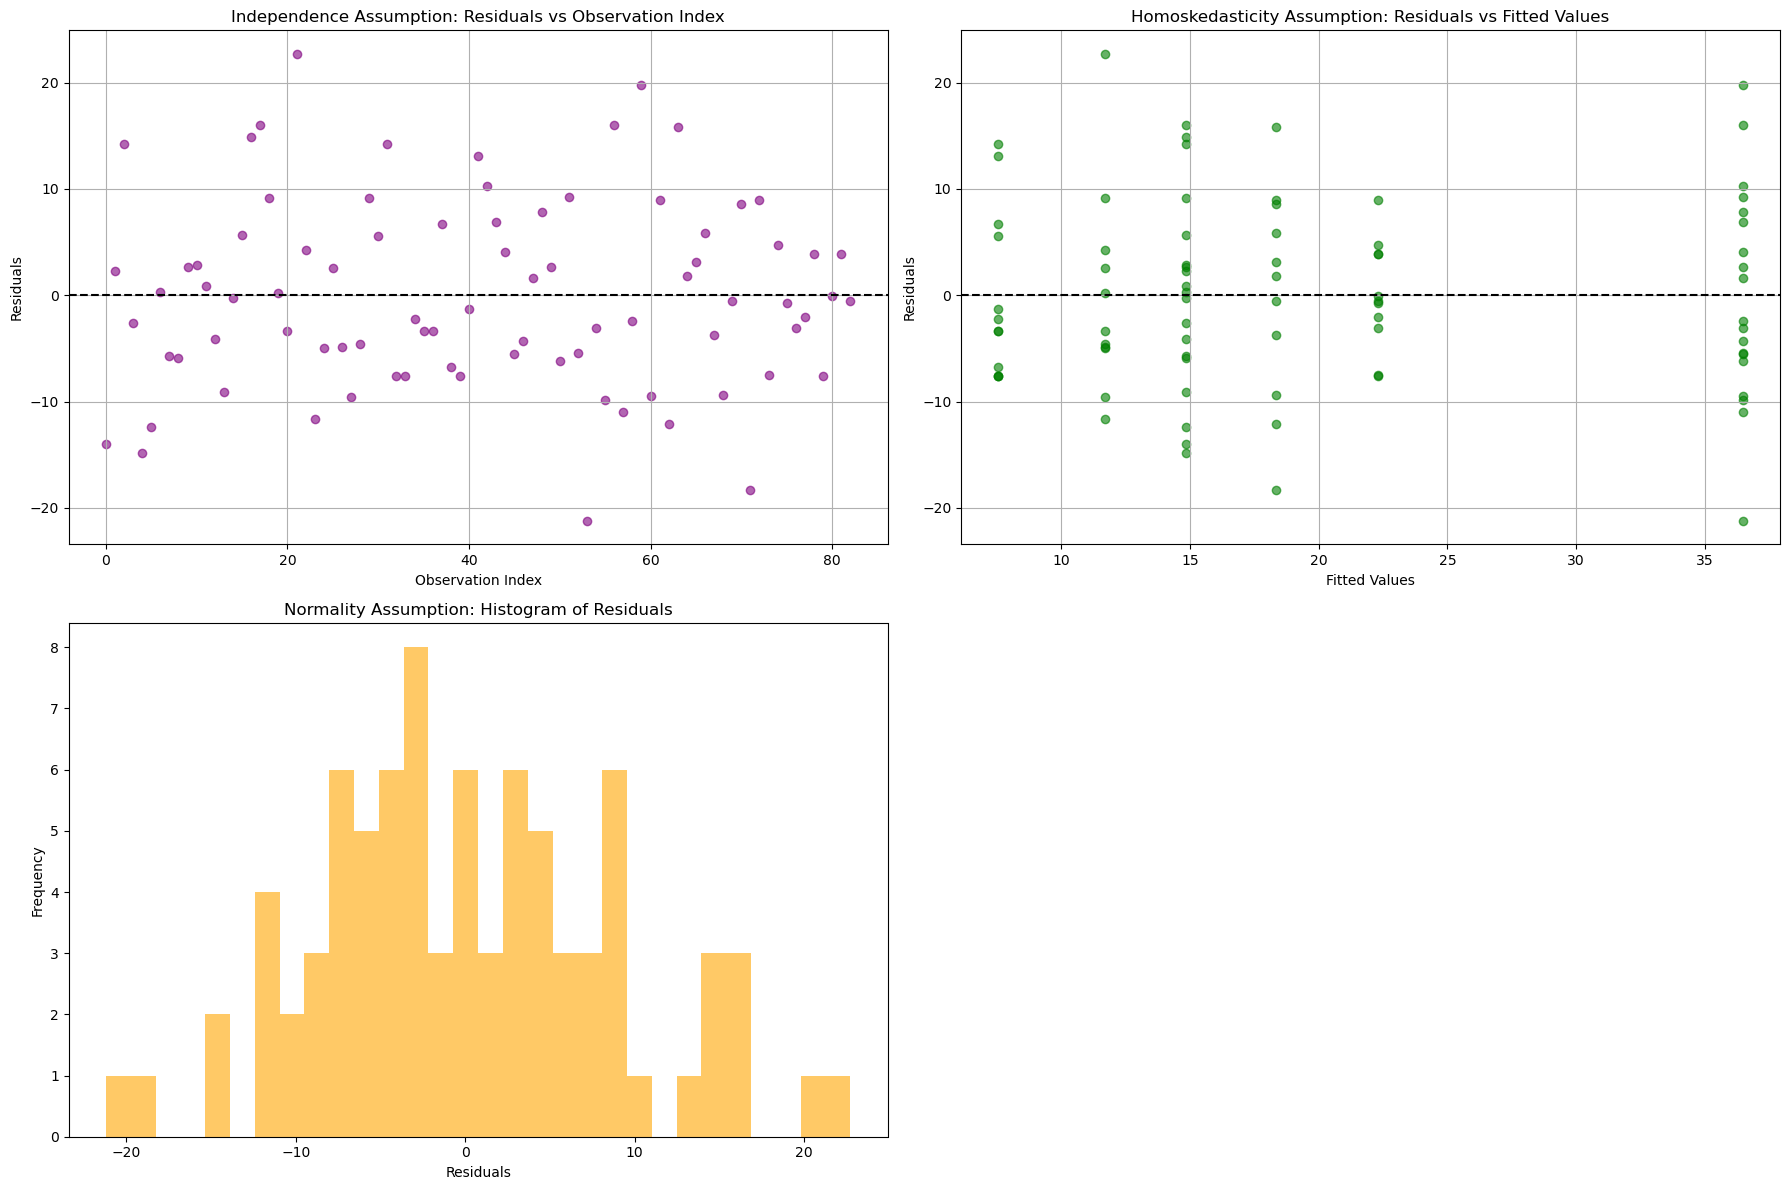


--- Multicollinearity Check (Variance Inflation Factor) ---
             Feature       VIF
1          Treatment  2.183893
2            Phase_2  2.320862
3            Phase_3  2.260621
4  Treatment_Phase_2  2.739379
5  Treatment_Phase_3  2.667089


In [74]:
trash_type = ['PaperContaminant','PlasticContaminant','CanContaminant']

for trash in trash_type:
    print(f"Regression for {trash}:")
    results = perform_regression(df, trash, f"{trash}", case = "Case 1")
    all_results.append(results)  # Append results to the list

### case_2 : balanced_data

Regression for PaperContaminant:
                            OLS Regression Results                            
Dep. Variable:       PaperContaminant   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     16.63
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           6.88e-11
Time:                        13:25:27   Log-Likelihood:                -165.72
No. Observations:                  78   AIC:                             343.4
Df Residuals:                      72   BIC:                             357.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const

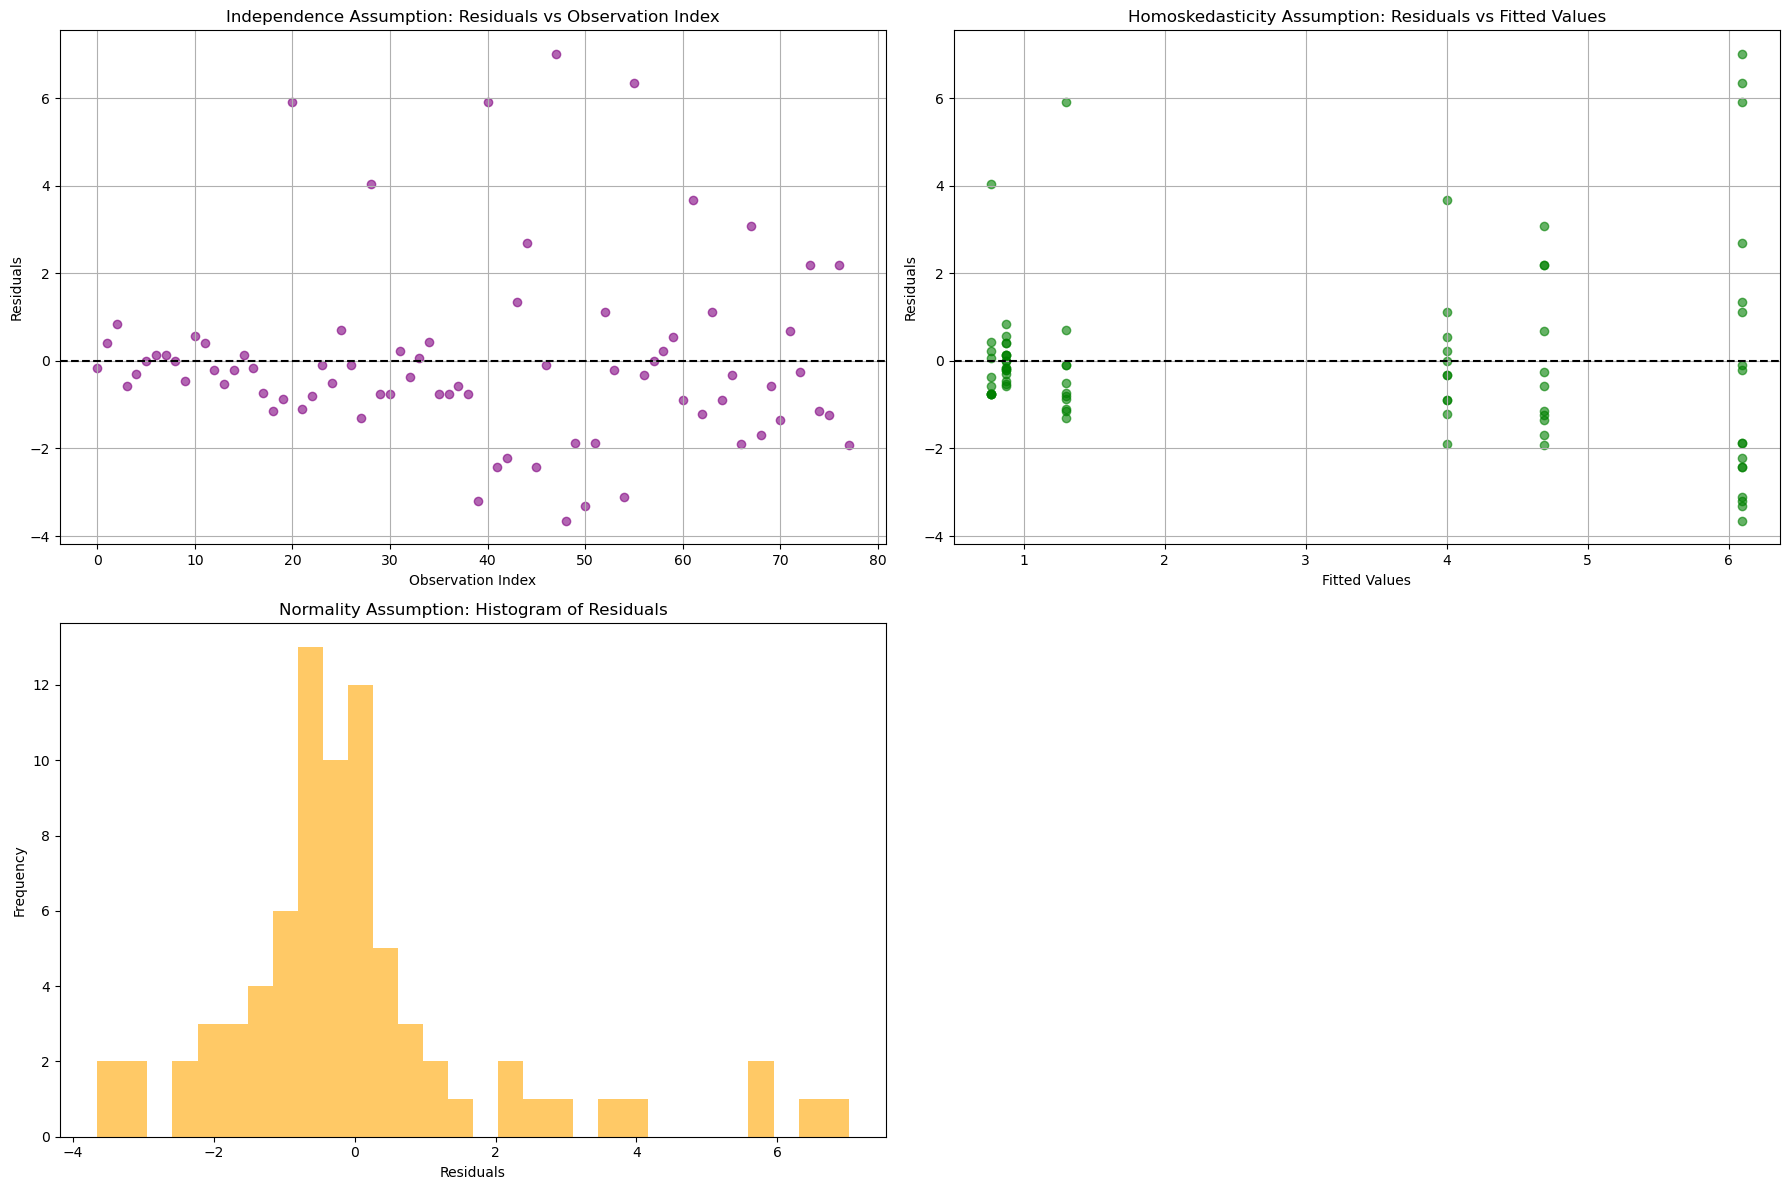


--- Multicollinearity Check (Variance Inflation Factor) ---
             Feature       VIF
1          Treatment  2.294118
2            Phase_2  2.365008
3            Phase_3  2.365008
4  Treatment_Phase_2  2.829563
5  Treatment_Phase_3  2.829563
Regression for PlasticContaminant:
                            OLS Regression Results                            
Dep. Variable:     PlasticContaminant   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     16.81
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           5.65e-11
Time:                        13:25:28   Log-Likelihood:                -274.33
No. Observations:                  78   AIC:                             560.7
Df Residuals:                      72   BIC:                             574.8
Df Model:                           5                                         
Covaria

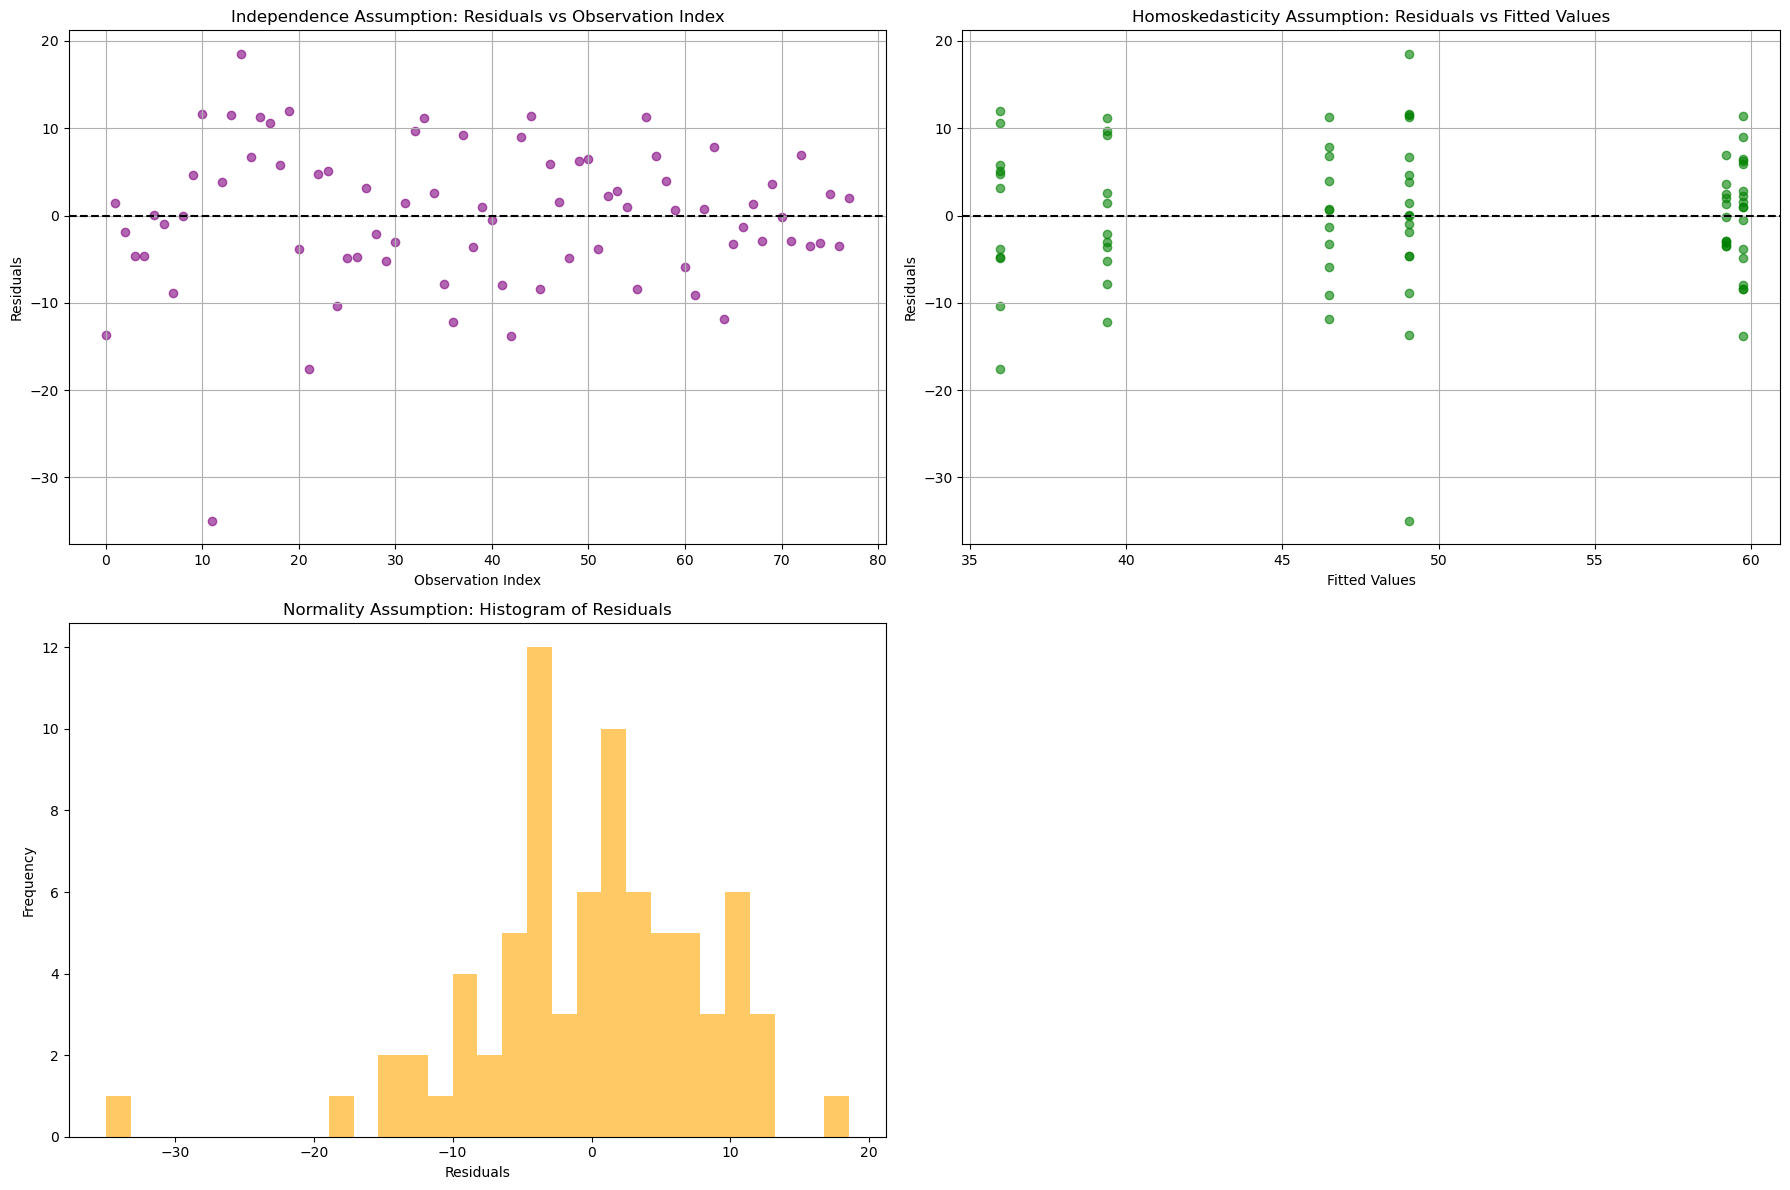


--- Multicollinearity Check (Variance Inflation Factor) ---
             Feature       VIF
1          Treatment  2.294118
2            Phase_2  2.365008
3            Phase_3  2.365008
4  Treatment_Phase_2  2.829563
5  Treatment_Phase_3  2.829563
Regression for CanContaminant:
                            OLS Regression Results                            
Dep. Variable:         CanContaminant   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     17.48
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           2.68e-11
Time:                        13:25:28   Log-Likelihood:                -279.32
No. Observations:                  78   AIC:                             570.6
Df Residuals:                      72   BIC:                             584.8
Df Model:                           5                                         
Covariance 

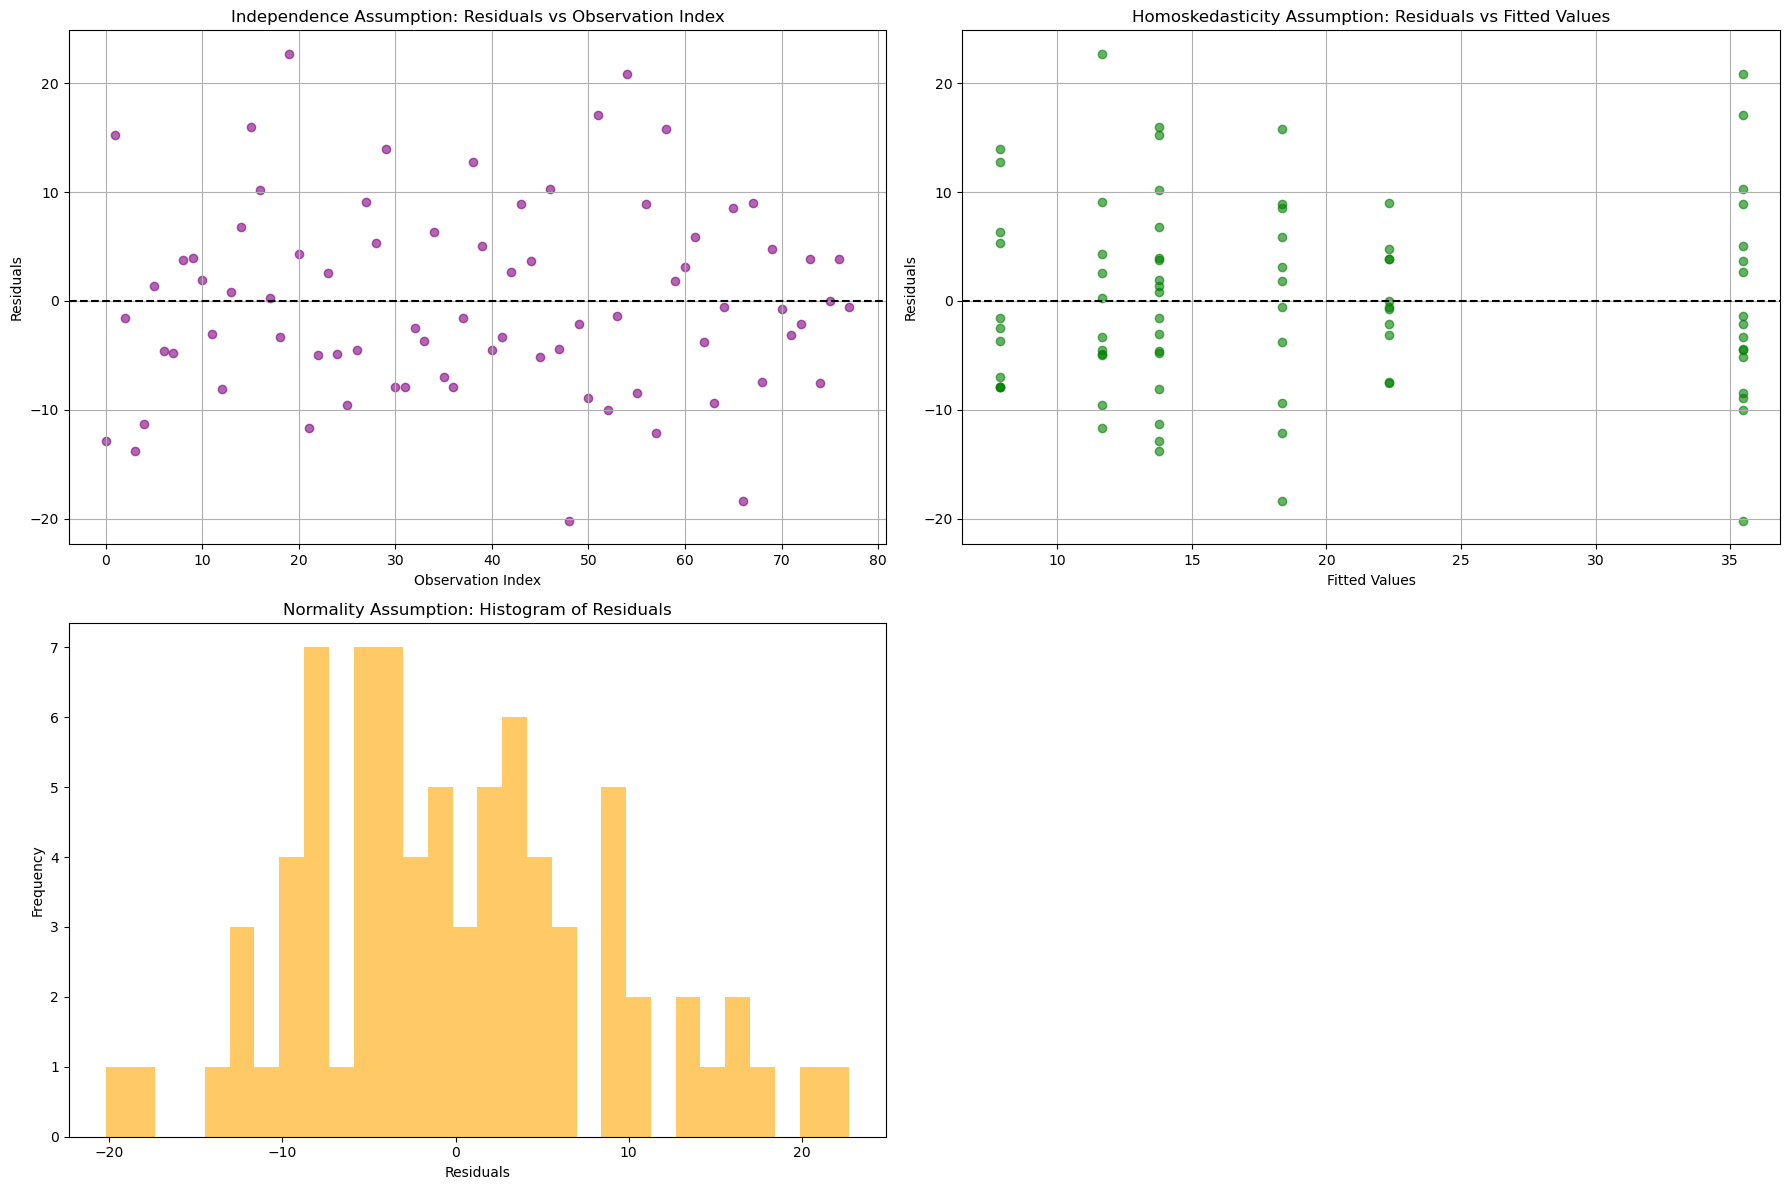


--- Multicollinearity Check (Variance Inflation Factor) ---
             Feature       VIF
1          Treatment  2.294118
2            Phase_2  2.365008
3            Phase_3  2.365008
4  Treatment_Phase_2  2.829563
5  Treatment_Phase_3  2.829563


In [75]:
trash_type = ['PaperContaminant','PlasticContaminant','CanContaminant']

for trash in trash_type:
    print(f"Regression for {trash}:")
    results = perform_regression(df_2, trash, f"{trash}", case = "Case 2")
    all_results.append(results)  # Append results to the list


### case_3 : balanced_data excluding Sunday

Regression for PaperContaminant:
                            OLS Regression Results                            
Dep. Variable:       PaperContaminant   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     15.05
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           1.85e-09
Time:                        13:25:28   Log-Likelihood:                -137.90
No. Observations:                  64   AIC:                             287.8
Df Residuals:                      58   BIC:                             300.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const

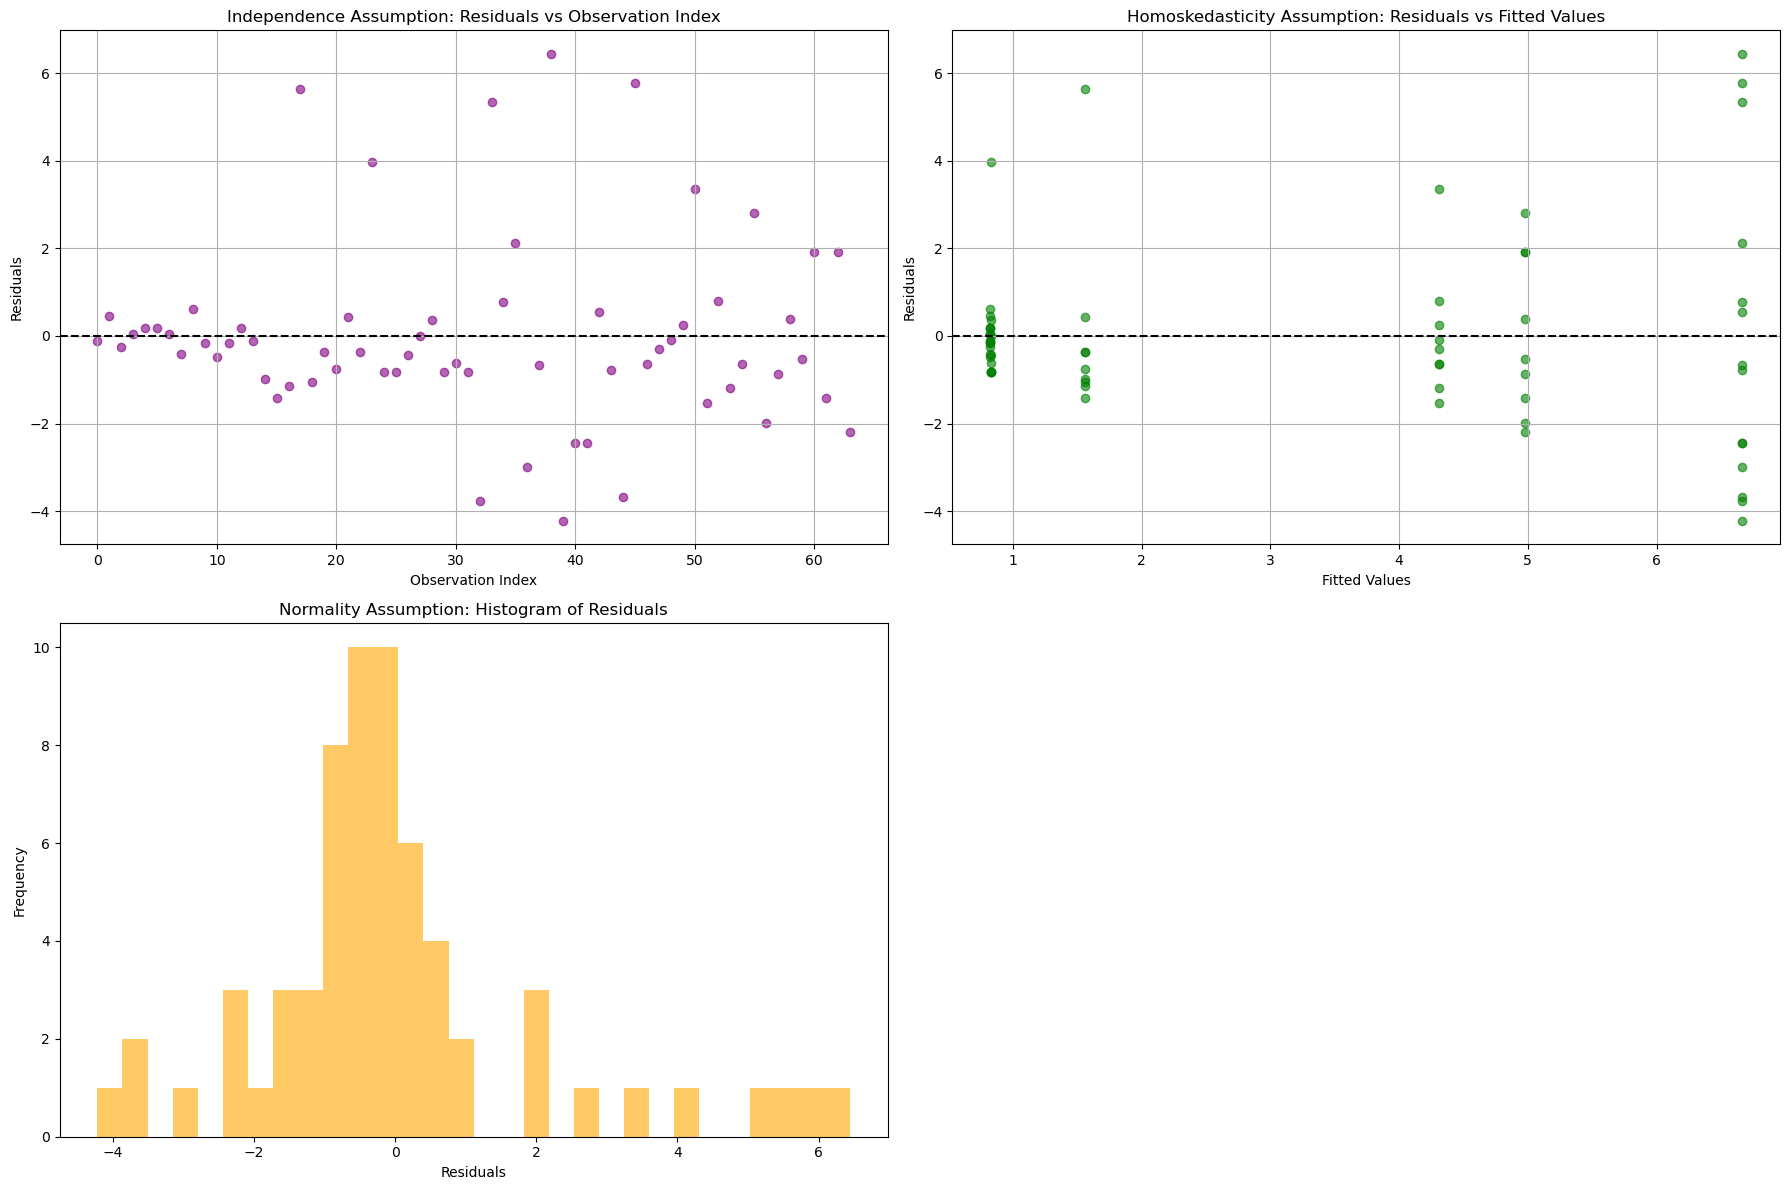


--- Multicollinearity Check (Variance Inflation Factor) ---
             Feature       VIF
1          Treatment  2.285714
2            Phase_2  2.361607
3            Phase_3  2.361607
4  Treatment_Phase_2  2.823661
5  Treatment_Phase_3  2.823661
Regression for PlasticContaminant:
                            OLS Regression Results                            
Dep. Variable:     PlasticContaminant   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     18.28
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           7.45e-11
Time:                        13:25:28   Log-Likelihood:                -213.34
No. Observations:                  64   AIC:                             438.7
Df Residuals:                      58   BIC:                             451.6
Df Model:                           5                                         
Covaria

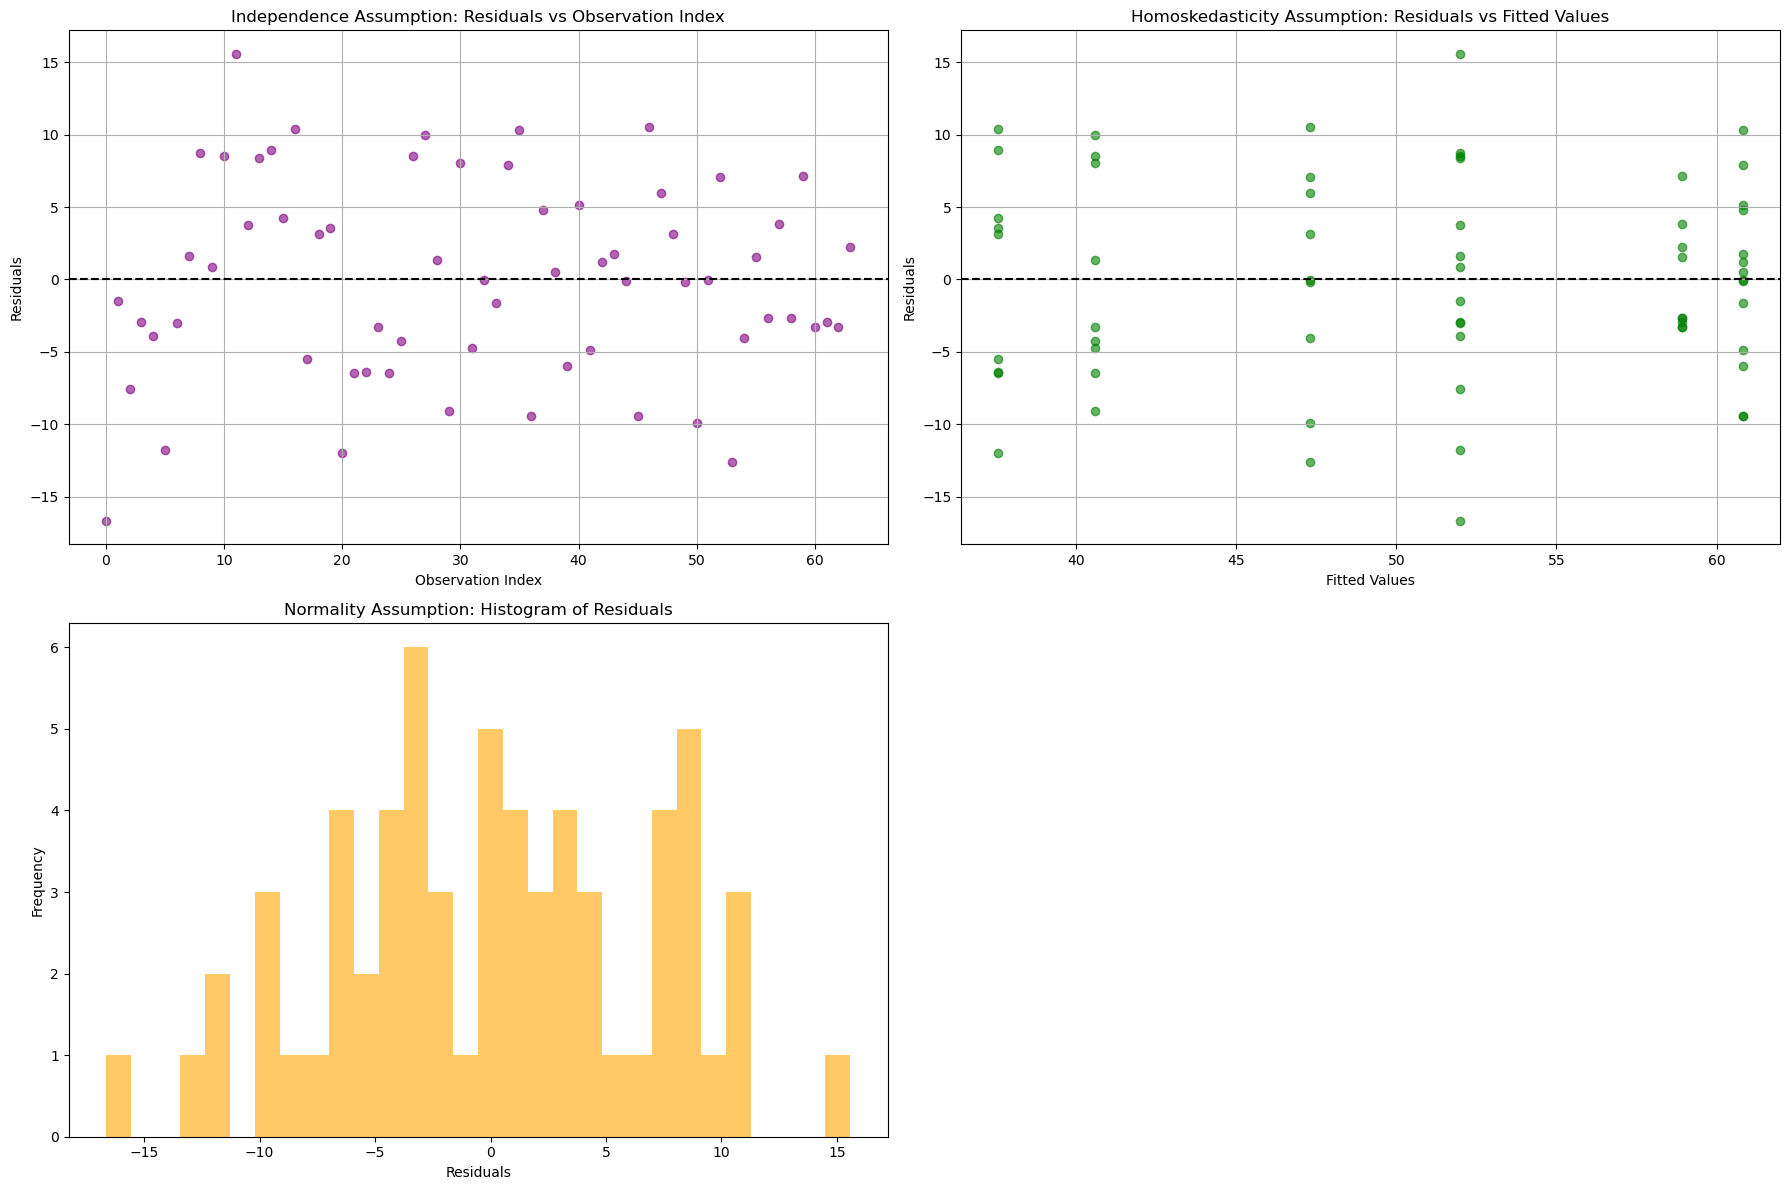


--- Multicollinearity Check (Variance Inflation Factor) ---
             Feature       VIF
1          Treatment  2.285714
2            Phase_2  2.361607
3            Phase_3  2.361607
4  Treatment_Phase_2  2.823661
5  Treatment_Phase_3  2.823661
Regression for CanContaminant:
                            OLS Regression Results                            
Dep. Variable:         CanContaminant   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     13.47
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           1.01e-08
Time:                        13:25:28   Log-Likelihood:                -229.09
No. Observations:                  64   AIC:                             470.2
Df Residuals:                      58   BIC:                             483.1
Df Model:                           5                                         
Covariance 

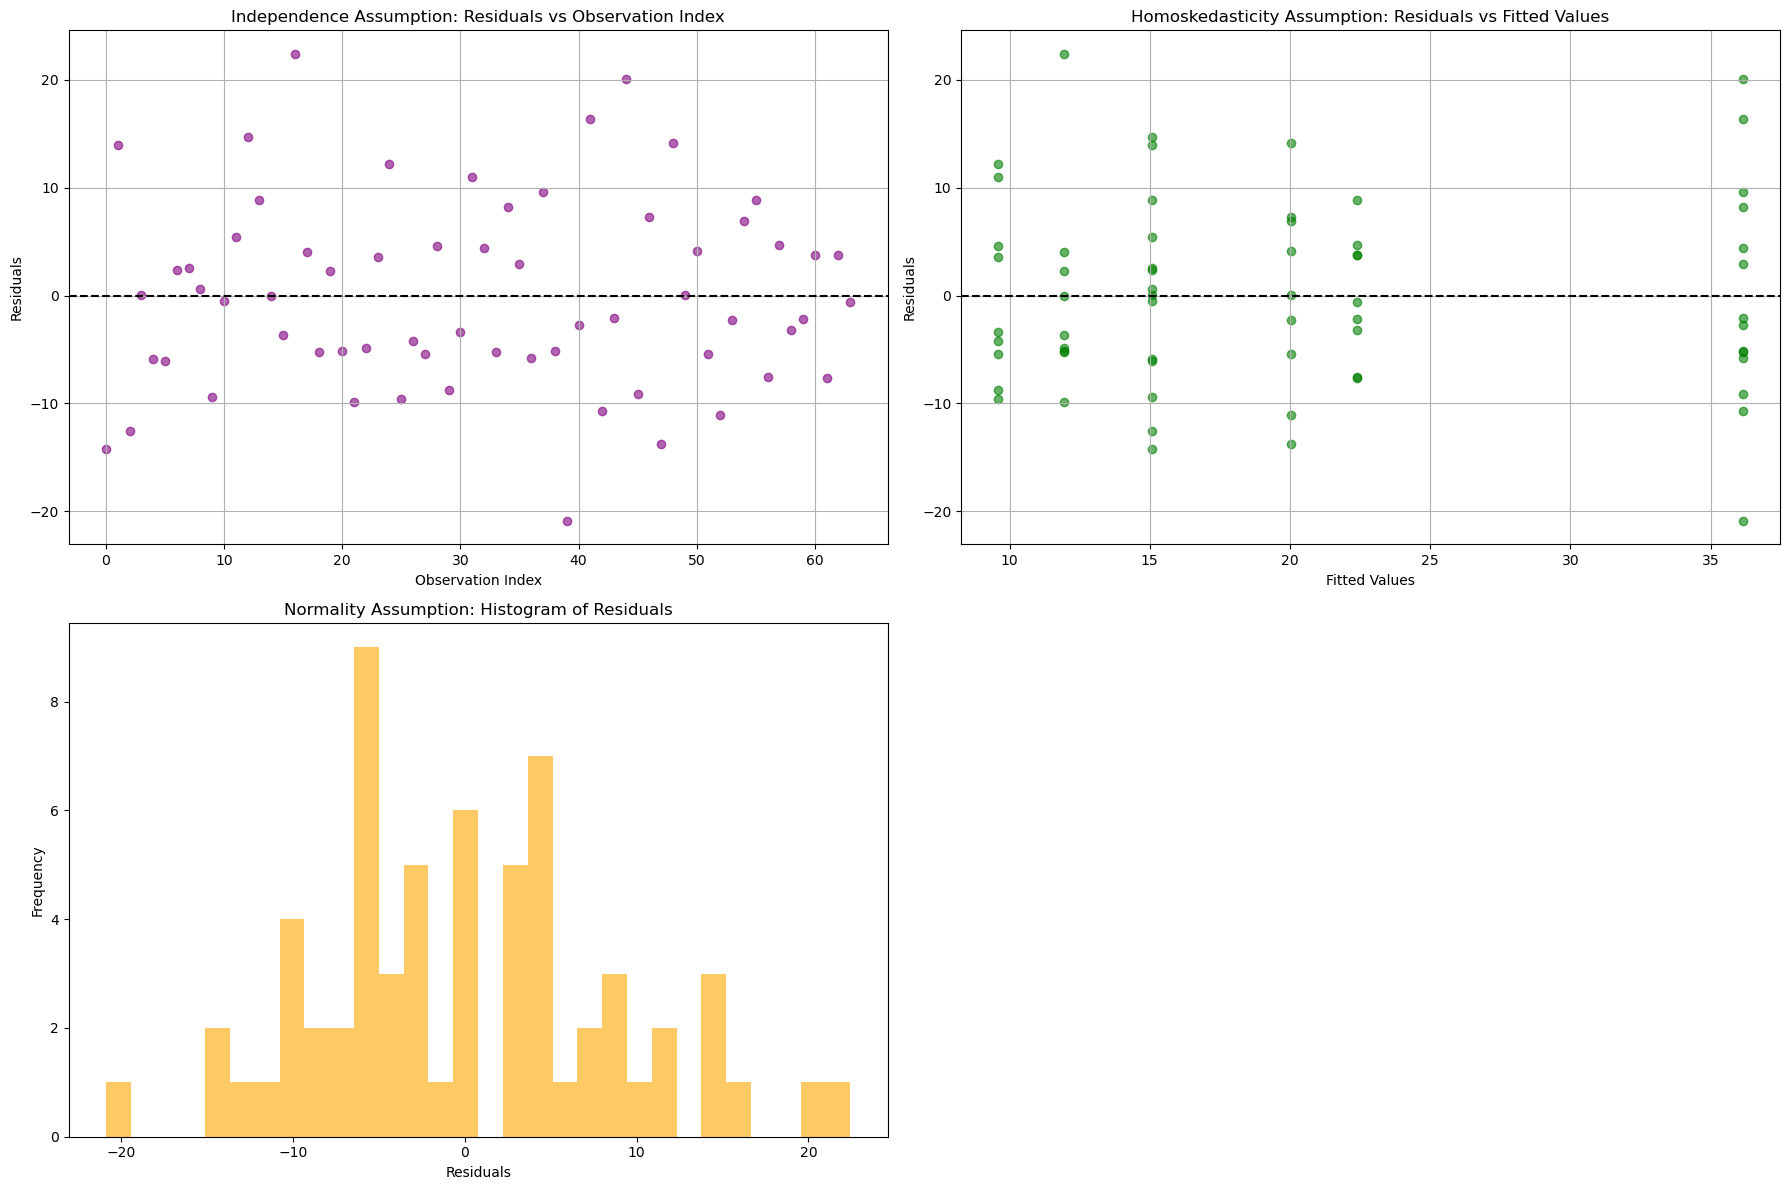


--- Multicollinearity Check (Variance Inflation Factor) ---
             Feature       VIF
1          Treatment  2.285714
2            Phase_2  2.361607
3            Phase_3  2.361607
4  Treatment_Phase_2  2.823661
5  Treatment_Phase_3  2.823661


In [76]:
trash_type = ['PaperContaminant','PlasticContaminant','CanContaminant']

for trash in trash_type:
    print(f"Regression for {trash}:")
    results = perform_regression(df_3, trash, f"{trash}", case = "Case 3")
    all_results.append(results)  # Append results to the list


In [77]:
# Concatenate all results into a single DataFrame
final_results = pd.concat(all_results, ignore_index=True)

# Write the final results to a CSV file
final_results.to_csv('regression_results.csv', index=False)

final_results

,Case,Phase&Trash,Variable,Coefficient,P-value
0,Case 1,PaperContaminant,const,0.853133,8.308944e-02
1,Case 1,PaperContaminant,Treatment,5.503592,9.753125e-12
2,Case 1,PaperContaminant,Phase_2,0.441672,5.836124e-01
3,Case 1,PaperContaminant,Phase_3,-0.100355,8.980841e-01
4,Case 1,PaperContaminant,Treatment_Phase_2,-2.798398,1.588495e-02
5,Case 1,PaperContaminant,Treatment_Phase_3,-1.565714,1.660257e-01
6,Case 1,PlasticContaminant,const,48.354130,3.778924e-38
7,Case 1,PlasticContaminant,Treatment,11.943908,5.198474e-05
8,Case 1,PlasticContaminant,Phase_2,-12.396228,2.780133e-04
9,Case 1,PlasticContaminant,Phase_3,-7.478979,2.071603e-02


# Parallel Trend Assumption Test

In [78]:
# Testing for parallelism assumption using Prof. Keppo's method from his paper
def parallel_assumption_regression(phase_data, dependent_var):
    # Define the independent variables (Treatment, Phase_2, Phase_3, Treatment_Phase_2, Treatment_Phase_3)
    X = phase_data[['Treatment', 'Phase_2', 'Phase_3','Treatment_Phase_1', 'Treatment_Phase_2', 'Treatment_Phase_3']] ##### 
    
    # Add a constant (intercept) to the independent variables
    X = sm.add_constant(X)
    
    # Define the dependent variable
    y = phase_data[dependent_var]
    
    # Fit the regression model
    model = sm.OLS(y, X).fit()
    
    # Print the summary of the regression
    print(model.summary())


for trash in trash_type:
    print(f"Parallel Assumption Regression for {trash}:")
    results = parallel_assumption_regression(df_3, trash)
    all_results.append(results)  # Append results to the list

Parallel Assumption Regression for PaperContaminant:
                            OLS Regression Results                            
Dep. Variable:       PaperContaminant   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     15.05
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           1.85e-09
Time:                        13:25:29   Log-Likelihood:                -137.90
No. Observations:                  64   AIC:                             287.8
Df Residuals:                      58   BIC:                             300.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

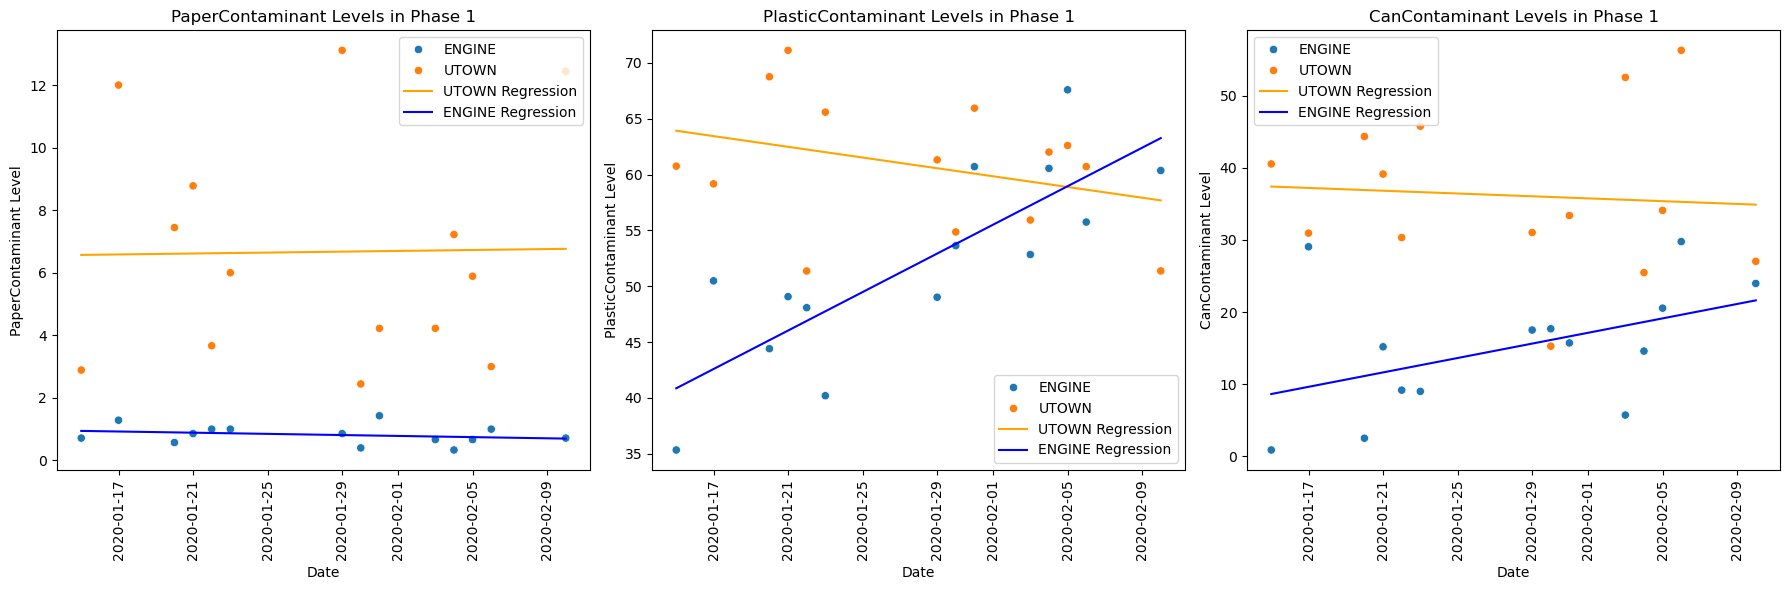

In [79]:
# Plot Phase 1 data for each contaminant type

import seaborn as sns

import statsmodels.api as sm

# Function to plot and perform linear regression
def plot_and_regress(df, contaminant, ax):
    # Filter data for Phase 1
    phase_1_data = df[df['FirstTrialPhase'] == 1]
    
    # Plot the data
    sns.scatterplot(data=phase_1_data, x='Date', y=contaminant, hue='Area', ax=ax)
    
    # Perform linear regression for UTOWN
    utown_data = phase_1_data[phase_1_data['Area'] == 'UTOWN']
    X_utown = sm.add_constant(utown_data['Date'].map(datetime.toordinal))
    y_utown = utown_data[contaminant]
    model_utown = sm.OLS(y_utown, X_utown).fit()
    ax.plot(utown_data['Date'], model_utown.predict(X_utown), color='orange', label='UTOWN Regression')
    
    # Perform linear regression for ENGINE
    engine_data = phase_1_data[phase_1_data['Area'] == 'ENGINE']
    X_engine = sm.add_constant(engine_data['Date'].map(datetime.toordinal))
    y_engine = engine_data[contaminant]
    model_engine = sm.OLS(y_engine, X_engine).fit()
    ax.plot(engine_data['Date'], model_engine.predict(X_engine), color='blue', label='ENGINE Regression')
    
    # Set plot title and labels
    ax.set_title(f'{contaminant} Levels in Phase 1')
    ax.set_xlabel('Date')
    ax.set_ylabel(f'{contaminant} Level')
    ax.legend()
    ax.tick_params(axis='x', rotation=90)

    return model_utown, model_engine

# Create subplots for each contaminant type
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot and regress for each contaminant type
models = []
for i, contaminant in enumerate(contaminant_types):
    model_utown, model_engine = plot_and_regress(df_3, contaminant, axs[i])
    models.append((model_utown, model_engine))

plt.tight_layout()
plt.show()

# Print the regression summaries
#for i, contaminant in enumerate(contaminant_types):
#    print(f"\nUTOWN Regression Summary for {contaminant}:")
#    print(models[i][0].summary())
#    print(f"\nENGINE Regression Summary for {contaminant}:")
#    print(models[i][1].summary())

# add control variable

In [81]:
df_2['weekend'] = df_2['dow'].apply(lambda x: 1 if x in ['Sunday','Saturday'] else 0 )

In [82]:
def perform_regression_2(phase_data, dependent_var, trash, case):
    '''
    include sunday as control variable
    '''
    # Define the independent variables (Treatment, Post, Treatment_Post)
    X = phase_data[['Treatment', 'Phase_2', 'Phase_3', 'Treatment_Phase_2', 'Treatment_Phase_3','weekend']]
    
    # Add a constant (intercept) to the independent variables
    X = sm.add_constant(X)
    
    # Define the dependent variable
    y = phase_data[dependent_var]
    
    # Fit the regression model
    model = sm.OLS(y, X).fit()

    results = pd.DataFrame({
        'Case': case,
        'Phase&Trash': trash,
        'Variable': model.params.index,
        'Coefficient': model.params.values,
        'P-value': model.pvalues.values
        
    })
    
    # Print the summary of the regression
    print(model.summary())
    
    return results

In [83]:
new_results = []
trash_type = ['PaperContaminant','PlasticContaminant','CanContaminant']

for trash in trash_type:
    print(f"Regression for {trash}:")
    results = perform_regression_2(df_2, trash, f"{trash}", case = "Case 2")
    new_results.append(results)  # Append results to the list

new_results = pd.concat(new_results, ignore_index=True)

Regression for PaperContaminant:
                            OLS Regression Results                            
Dep. Variable:       PaperContaminant   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     15.47
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           2.93e-11
Time:                        13:25:29   Log-Likelihood:                -163.05
No. Observations:                  78   AIC:                             340.1
Df Residuals:                      71   BIC:                             356.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const

In [84]:
check = pd.merge(final_results, new_results, on=['Case','Phase&Trash','Variable'], suffixes=['_before','_after'])

In [85]:
# weekend p-value check
new_results[new_results['Variable']=='weekend']

,Case,Phase&Trash,Variable,Coefficient,P-value
6,Case 2,PaperContaminant,weekend,-1.357032,0.028081
13,Case 2,PlasticContaminant,weekend,-7.562151,0.001992
20,Case 2,CanContaminant,weekend,-5.412889,0.041674


In [86]:
# sensitivity check -> almost no change in coefficient_before(no control variable) vs coefficient_after(add control variable)
diff = check[(check.Variable=='Treatment_Phase_2') |(check.Variable=='Treatment_Phase_3')][['Case','Phase&Trash','Variable','Coefficient_before','Coefficient_after','P-value_before','P-value_after']]
diff

,Case,Phase&Trash,Variable,Coefficient_before,Coefficient_after,P-value_before,P-value_after
4,Case 2,PaperContaminant,Treatment_Phase_2,-2.523377,-2.523377,0.031951,0.027691
5,Case 2,PaperContaminant,Treatment_Phase_3,-1.304582,-1.304582,0.261826,0.249065
10,Case 2,PlasticContaminant,Treatment_Phase_2,-0.138705,-0.138705,0.976248,0.974762
11,Case 2,PlasticContaminant,Treatment_Phase_3,9.099827,9.099827,0.053858,0.040864
16,Case 2,CanContaminant,Treatment_Phase_2,-15.024421,-15.024421,0.003340,0.002738
17,Case 2,CanContaminant,Treatment_Phase_3,-7.243120,-7.243120,0.147705,0.138927


In [87]:
diff.to_excel('sensitivity.xlsx')

# placebo 

In [88]:
fake_date = df_2[df_2['FirstTrialPhase']==1]['Date'].median()
phase1_end = datetime(2020, 2, 9)
fake_date

Timestamp('2020-01-29 00:00:00')

In [89]:
df_4 = df_2.copy()
max(df_4.Date)

Timestamp('2020-03-17 00:00:00')

In [90]:
def perform_regression(phase_data, dependent_var, trash, case):
    # Define the independent variables (Treatment, Post, Treatment_Post)
    X = phase_data[['Treatment', 'Phase_2', 'Treatment_Phase_2']]
    
    # Add a constant (intercept) to the independent variables
    X = sm.add_constant(X)
    
    # Define the dependent variable
    y = phase_data[dependent_var]
    
    # Fit the regression model
    model = sm.OLS(y, X).fit()

    results = pd.DataFrame({
        'Case': case,
        'Phase&Trash': trash,
        'Variable': model.params.index,
        'Coefficient': model.params.values,
        'P-value': model.pvalues.values
    })
    
    # Print the summary of the regression
    print(model.summary())


    return results

In [91]:
# preprocessing

# Adding a new column 'Treatment' that returns 1 when Area is UTOWN and 0 when Area is ENGINE
df_4['Treatment'] = df_4['Area'].apply(lambda x: 1 if x == 'UTOWN' else 0)

# Adding two new columns 'Phase_2' and 'Phase_3'
df_4['Phase_1'] = df_4['Date'].apply(lambda x: 1 if x <= fake_date else 0) ####### ADDED FOR PARALLELISM TEST
df_4['Phase_2'] = df_4['Date'].apply(lambda x: 1 if (x > fake_date) & (x < phase1_end) else 0)
# df_4['Phase_3'] = df_4['FirstTrialPhase'].apply(lambda x: 1 if x == 3 else 0)

# Adding a new column 'Treatment_Post' which is the product of 'Treatment' and 'Phase' columns
df_4['Treatment_Phase_1'] = df_4['Treatment'] * df_4['Phase_1'] ####### ADDED FOR PARALLELISM TEST
df_4['Treatment_Phase_2'] = df_4['Treatment'] * df_4['Phase_2']

In [92]:
all_results = []
trash_type = ['PaperContaminant','PlasticContaminant','CanContaminant']

for trash in trash_type:
    print(f"Regression for {trash}:")
    results = perform_regression(df_4, trash, f"{trash}", case = "Case 2")
    all_results.append(results)  # Append results to the list

# Concatenate all results into a single DataFrame
final_results = pd.concat(all_results, ignore_index=True)

Regression for PaperContaminant:
                            OLS Regression Results                            
Dep. Variable:       PaperContaminant   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     24.29
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           4.79e-11
Time:                        13:25:29   Log-Likelihood:                -168.93
No. Observations:                  78   AIC:                             345.9
Df Residuals:                      74   BIC:                             355.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const

In [93]:
final_results['P-value'] = final_results['P-value'].apply(lambda x: round(x, 5))

In [94]:
final_results[final_results.Variable=='Treatment_Phase_2']

,Case,Phase&Trash,Variable,Coefficient,P-value
3,Case 2,PaperContaminant,Treatment_Phase_2,-0.878442,0.49419
7,Case 2,PlasticContaminant,Treatment_Phase_2,-5.110798,0.36944
11,Case 2,CanContaminant,Treatment_Phase_2,3.660566,0.54436
